### This notebook actually calculates a representative subsample of GBS. ROC Curves are therefore combined with increasing brightness to demonstrate the progress. Iterations stop around 0.5.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gbs = pd.read_csv('gbs_processed.csv', encoding = "ISO-8859-1", delimiter = ',')
gesis = pd.read_csv('gesis_processed.csv', encoding = "ISO-8859-1", delimiter = ',')

gbs = gbs.fillna(gbs.median()) #if there still happens to be something missing for some reason
gesis = gesis.fillna(gesis.median()) #if there still happens to be something missing for some reason

gesis.drop(columns = ['GESIS-CODE'], axis=1, inplace = True)
gbs.drop(columns = ['GBS-CODE', 'Gruppe'], axis=1, inplace = True)

gbs['Umfrage'] = 1
gesis['Umfrage'] = 0

drop = ['Personen im Haushalt',
       'Nettoeinkommen Selbst', 'Nettoeinkommen Haushalt', 'Schlechter Schlaf',
       'Leben genießen', 'Zu Nichts aufraffen', 'Alles anstrengend',
       'Wahlteilnahme', 'Wahlabsicht', 'Desinteresse Politiker',
       'Zufriedenheit Leben', 'Aktiv', 'Verärgert', 'Wach', 'Nervös', 'Ängstlich',
       'Geburtsjahr', 'Geburtsland', 'Nationalitaet',
       'Familienstand', 'Hoechster Bildungsabschluss', 'Berufliche Ausbildung',
       'Erwerbstaetigkeit', 'Berufsgruppe']

gbs.drop(columns=drop, axis=1, inplace=True)
gesis.drop(columns=drop, axis=1, inplace=True)

gbs_base = gbs.copy()

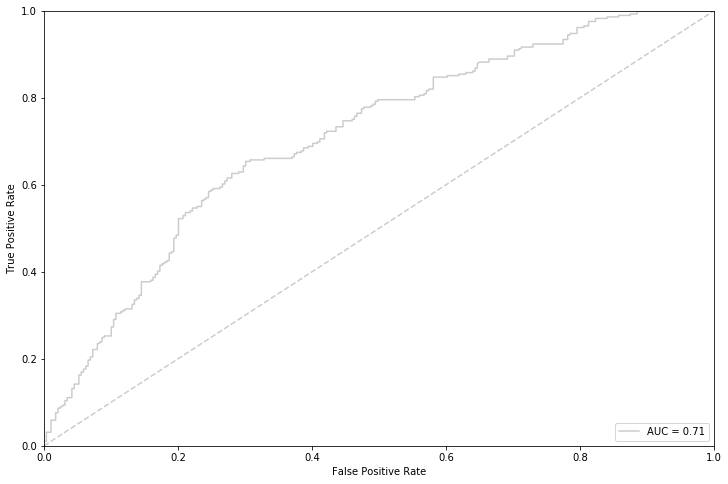

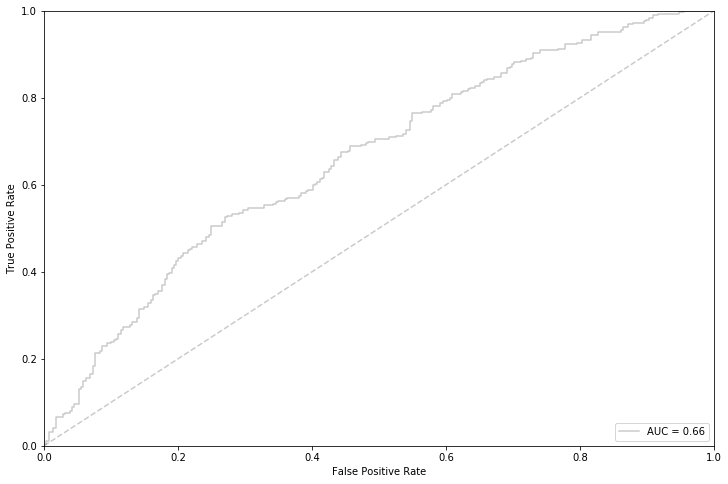

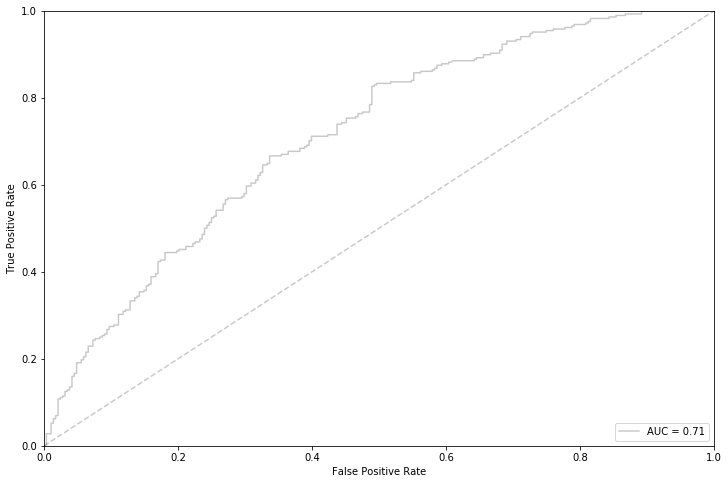

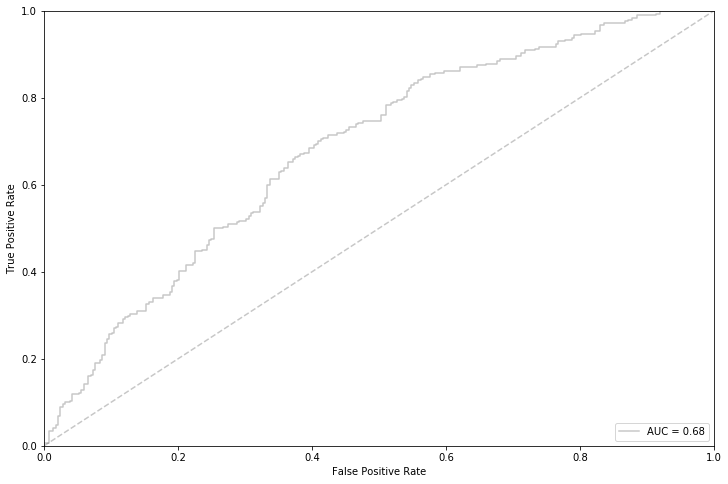

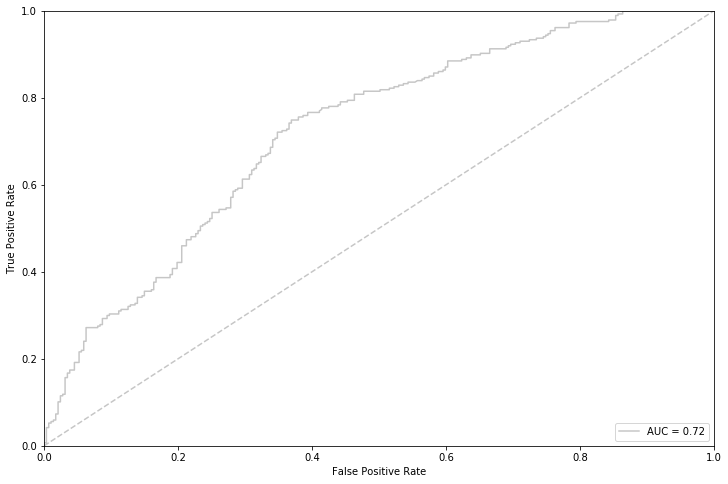

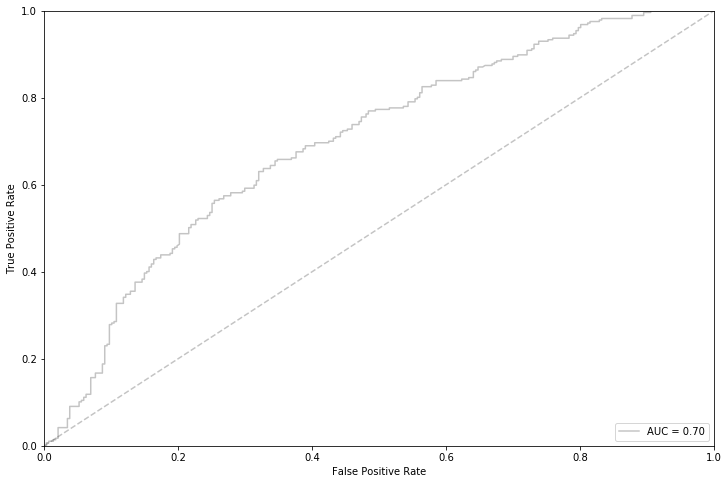

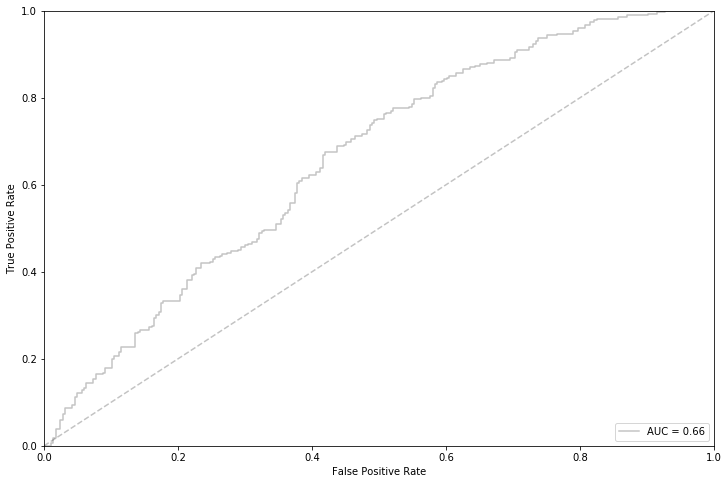

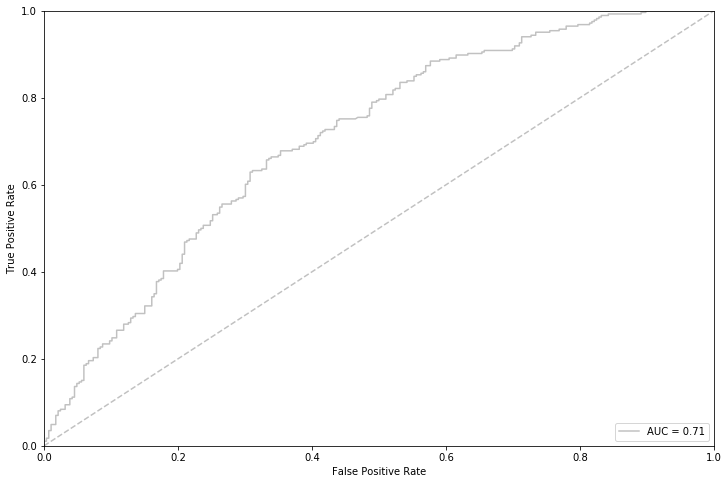

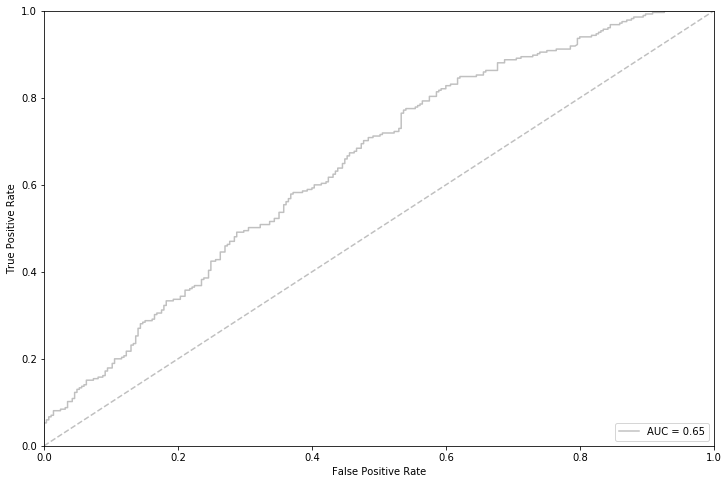

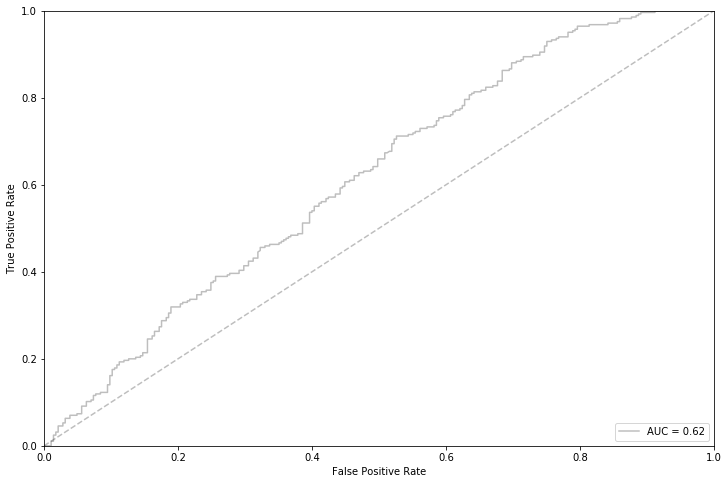

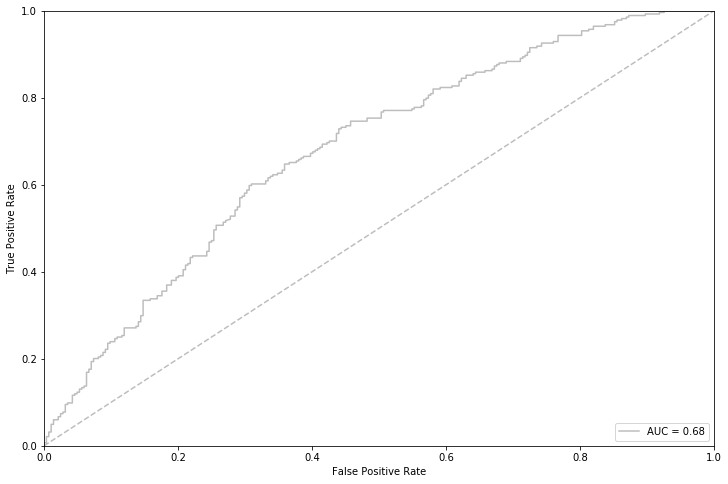

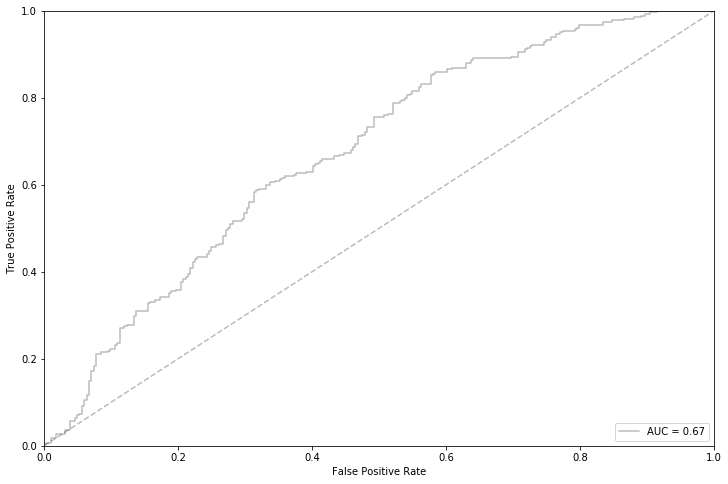

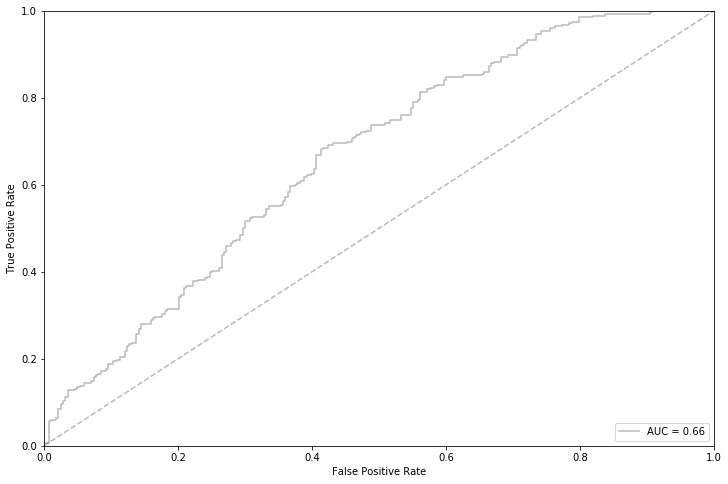

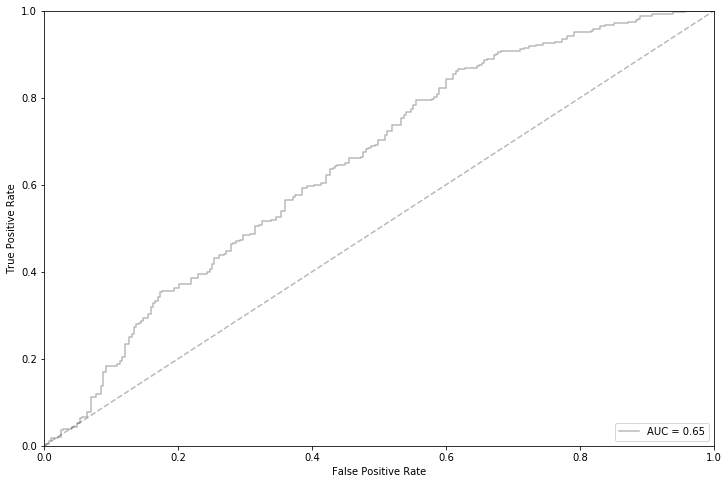

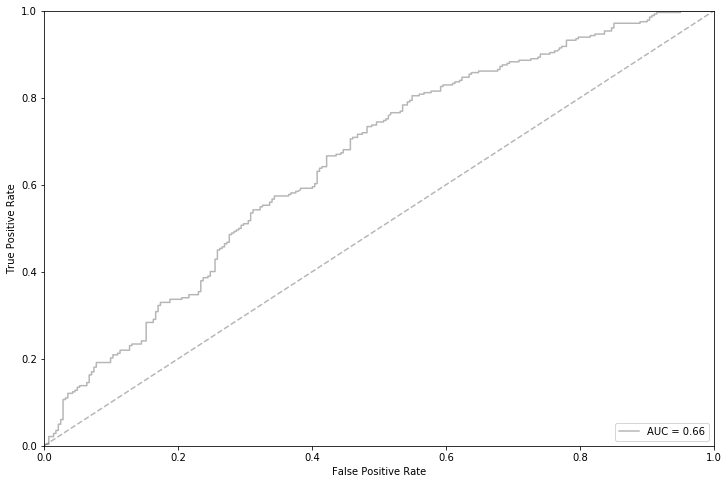

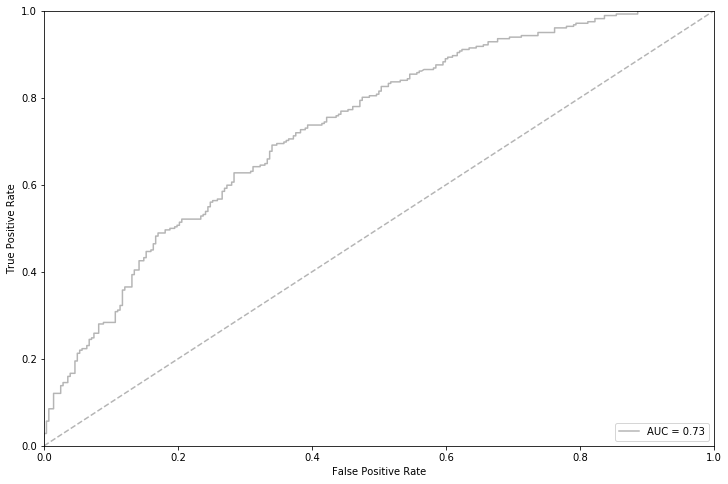

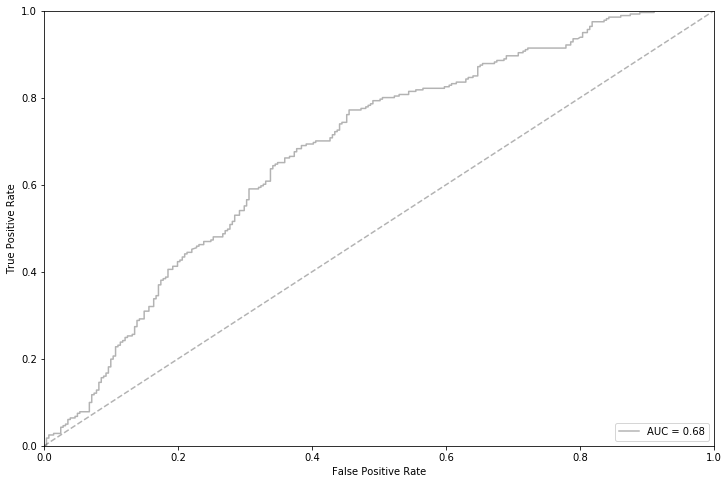

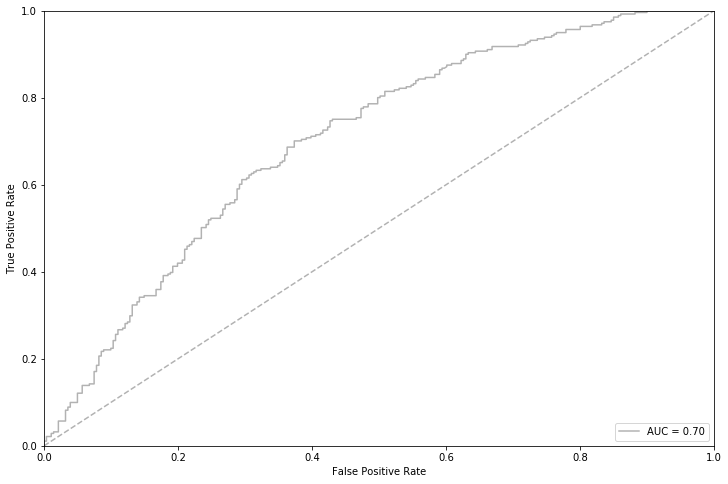

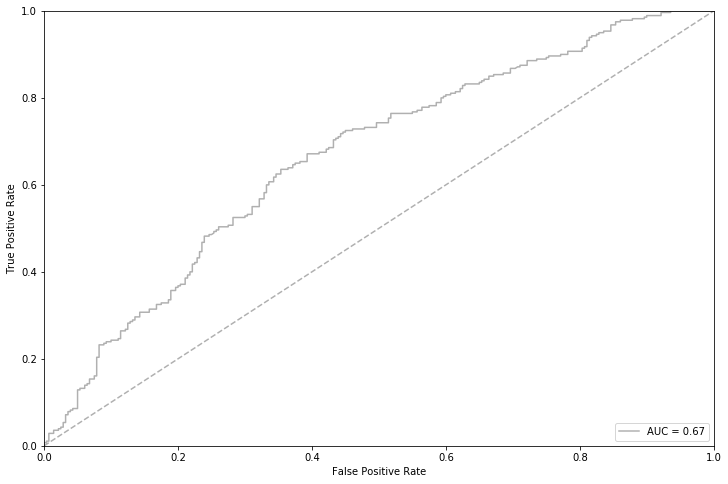

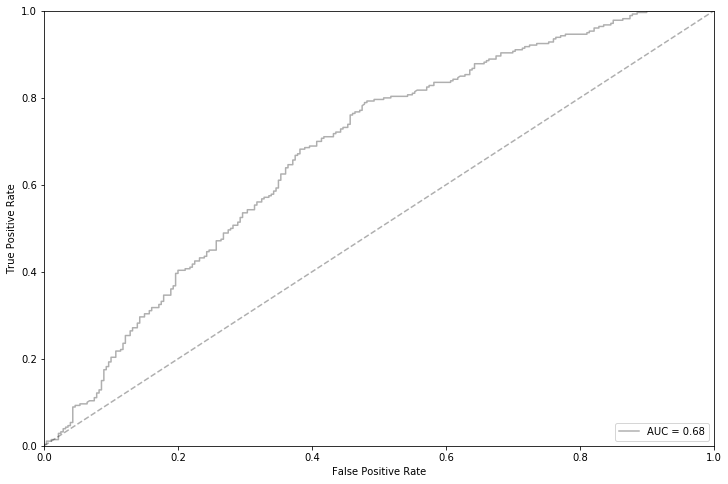

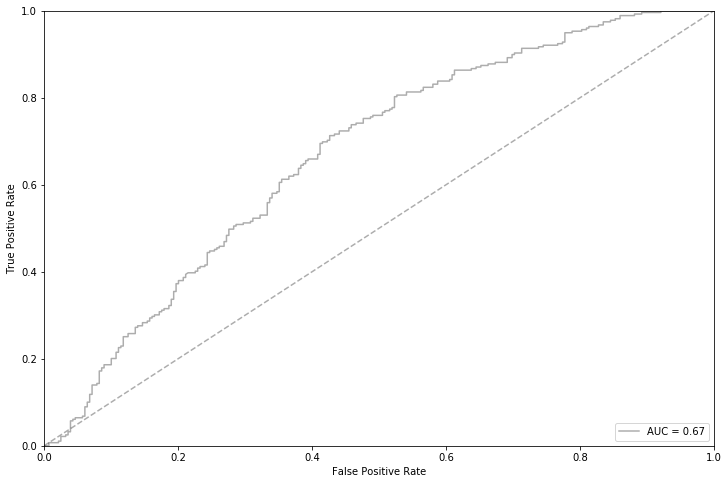

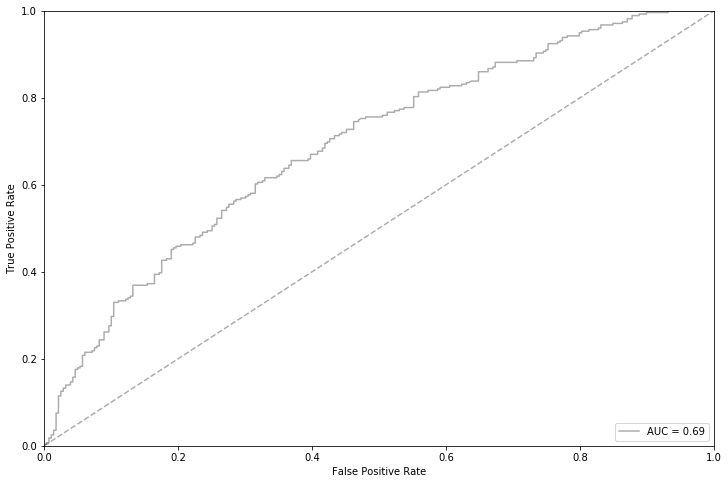

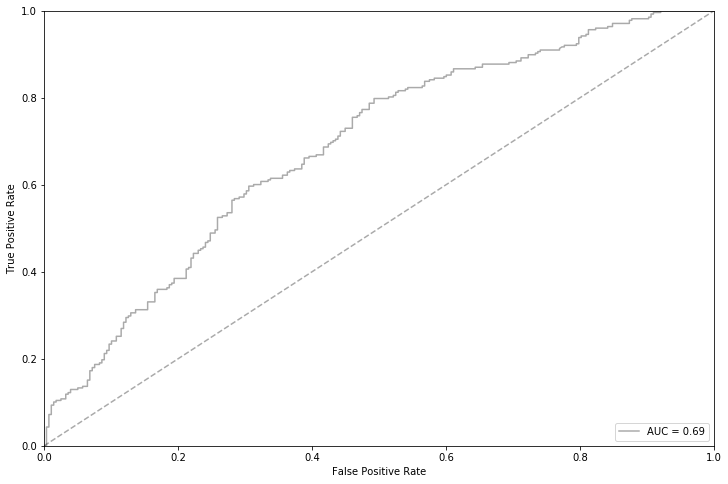

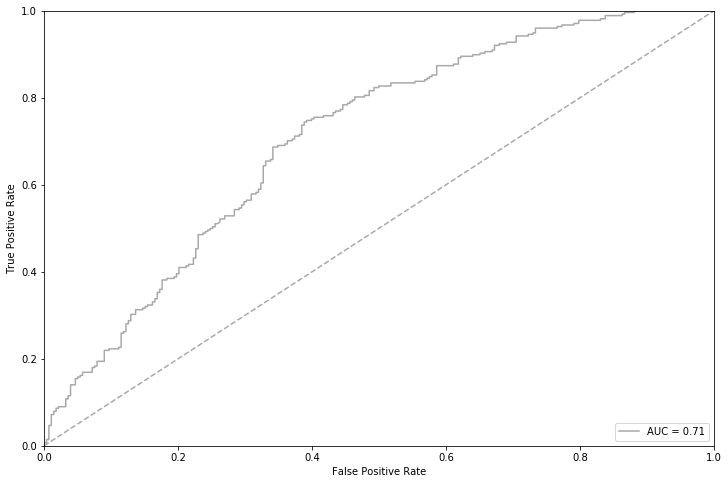

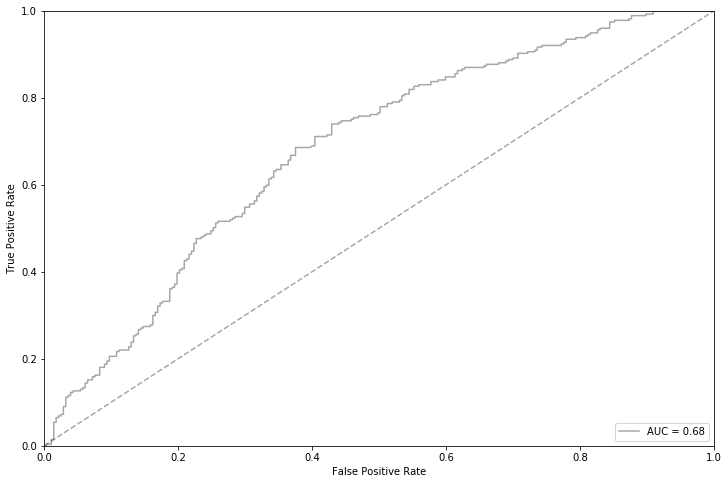

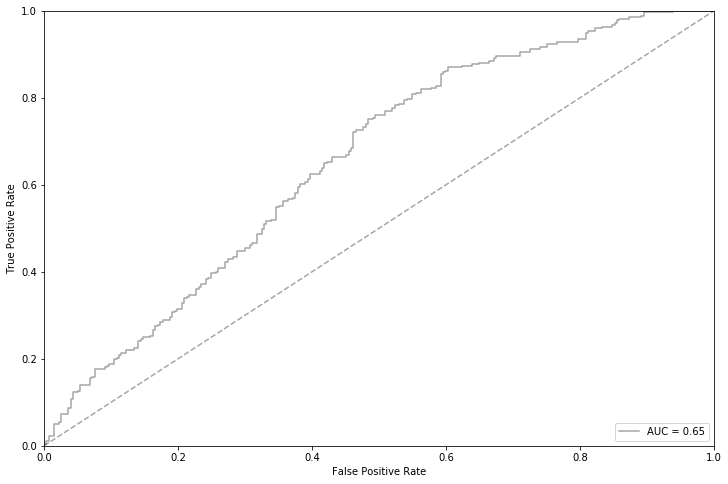

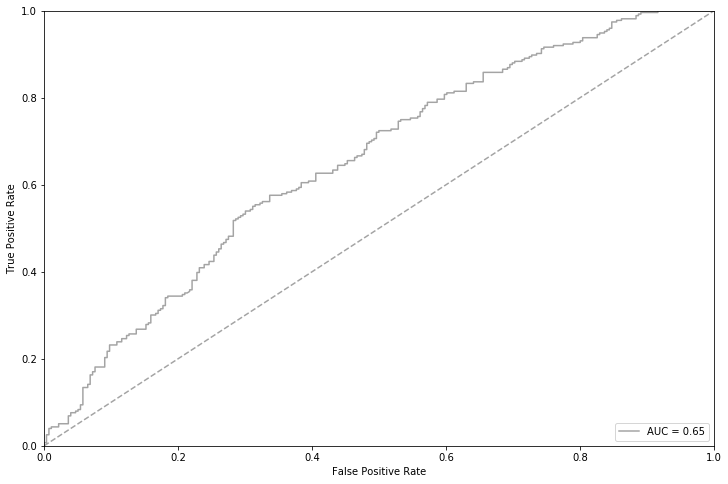

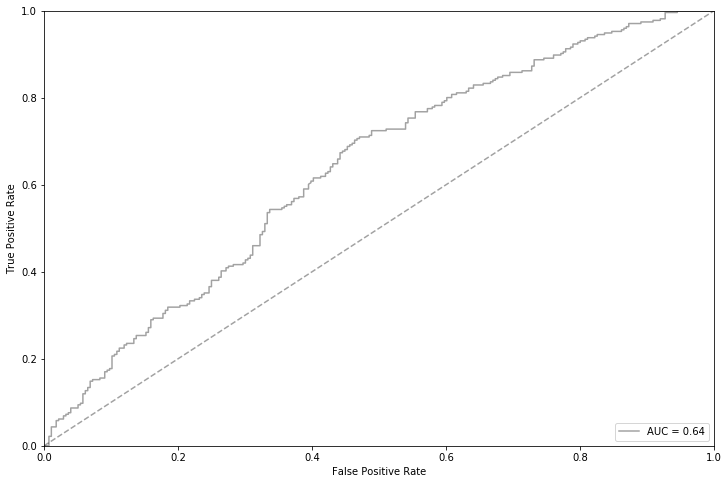

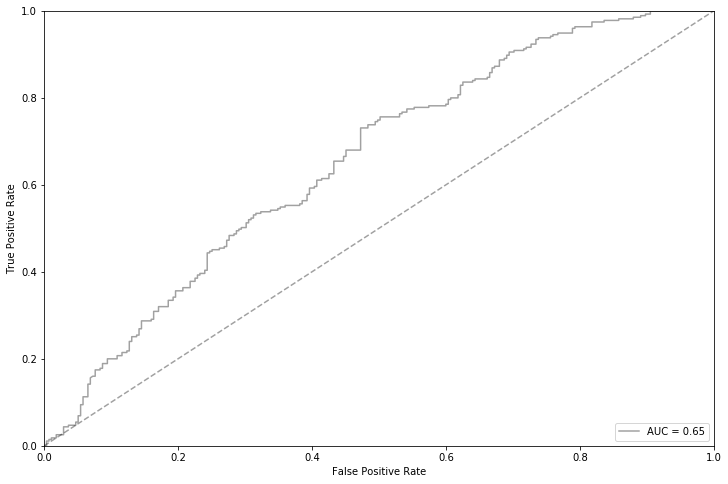

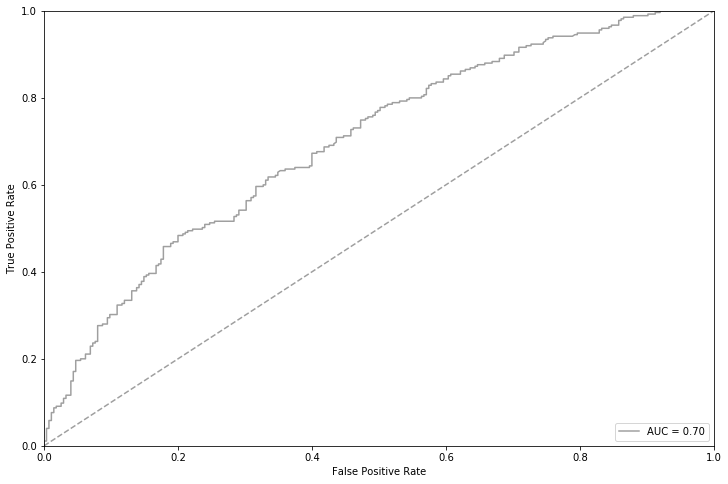

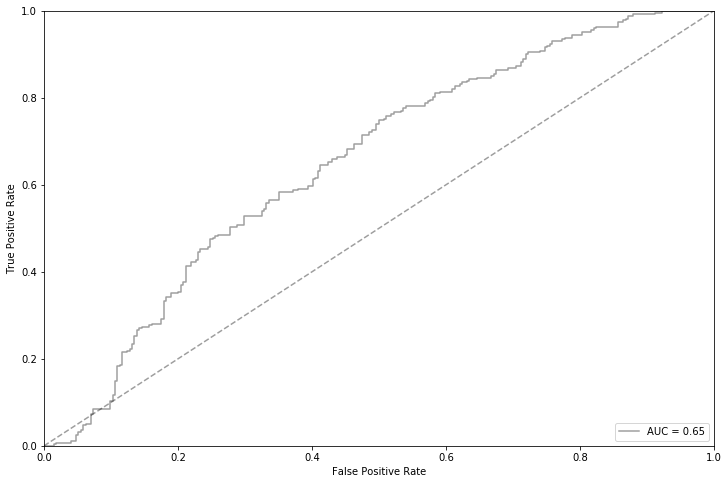

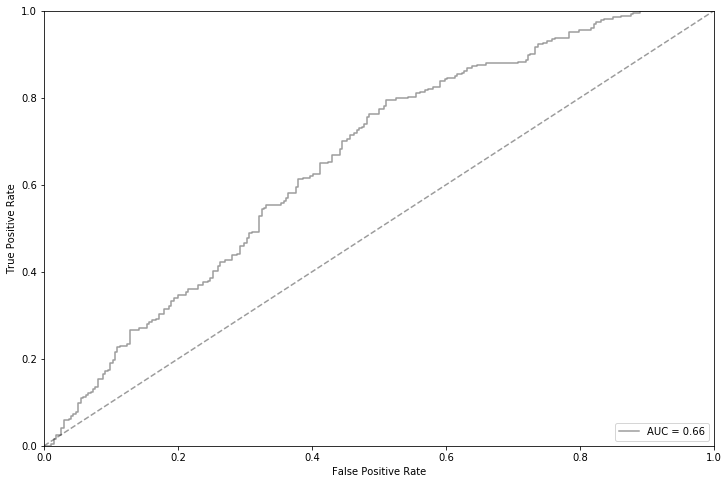

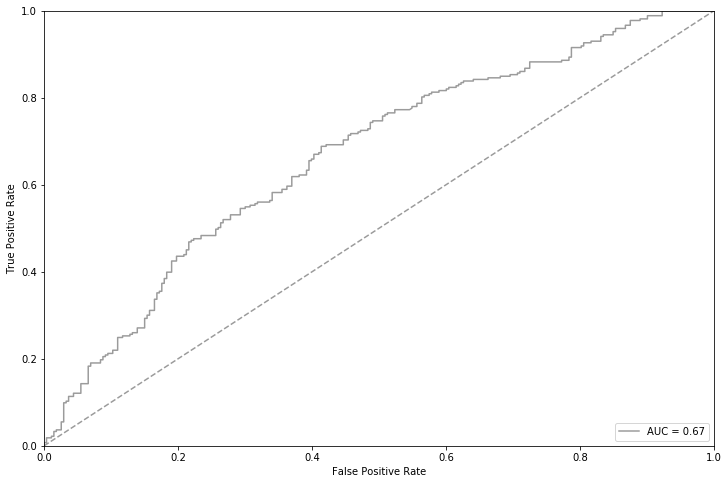

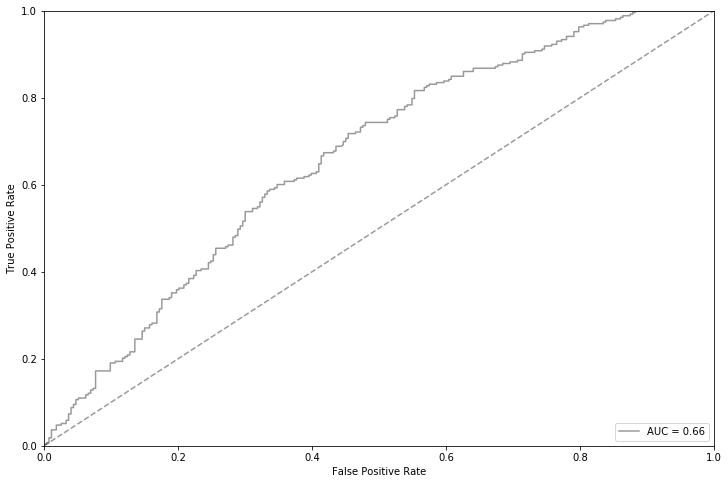

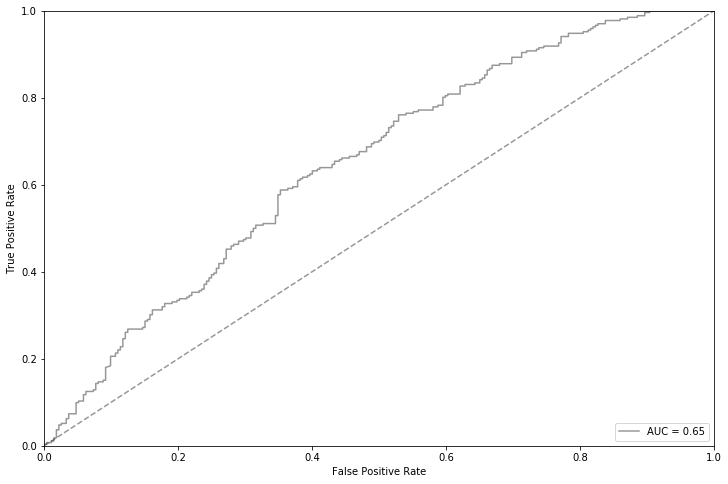

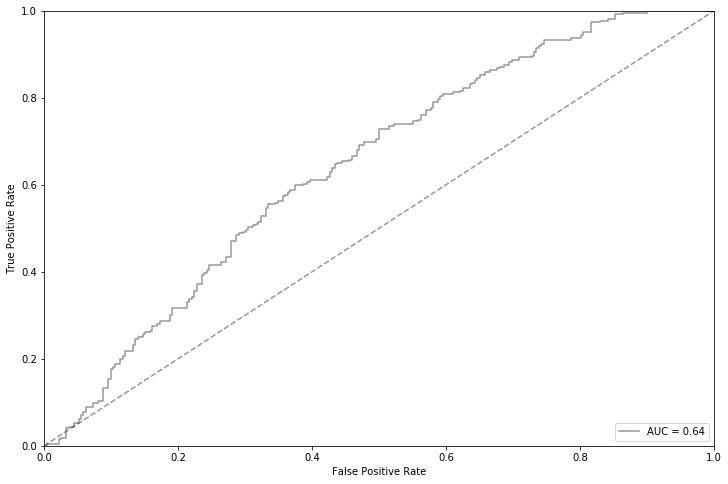

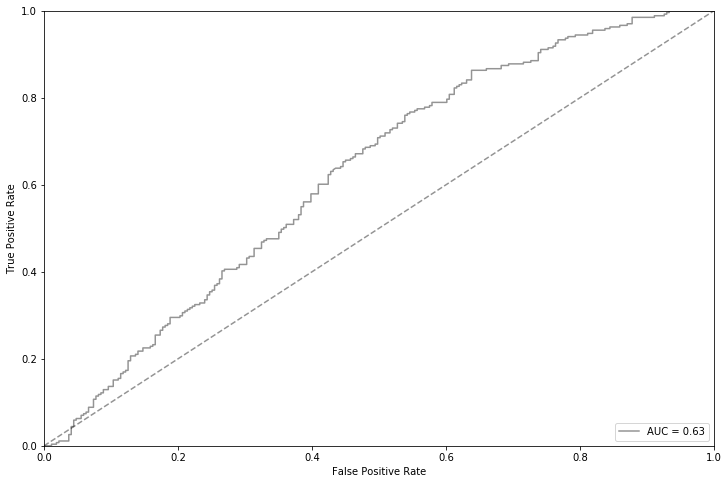

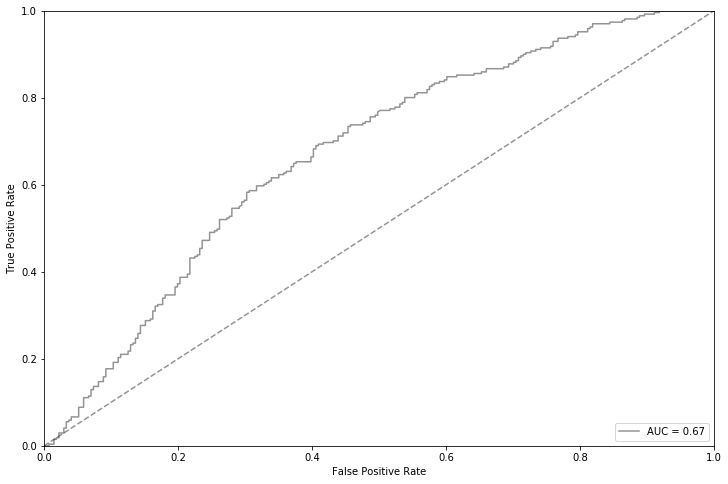

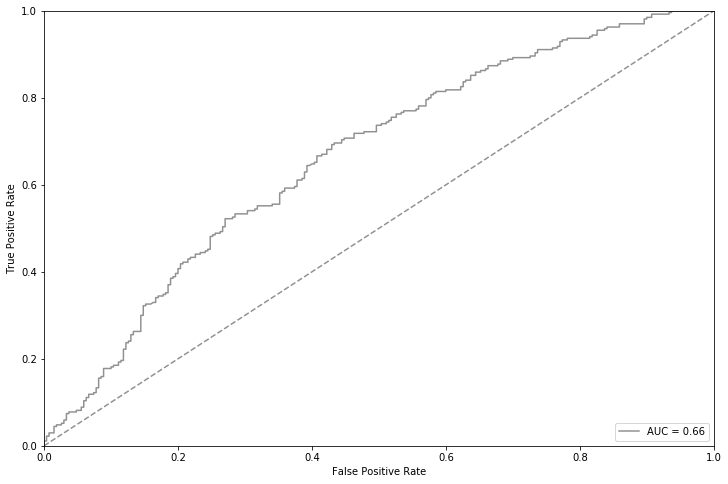

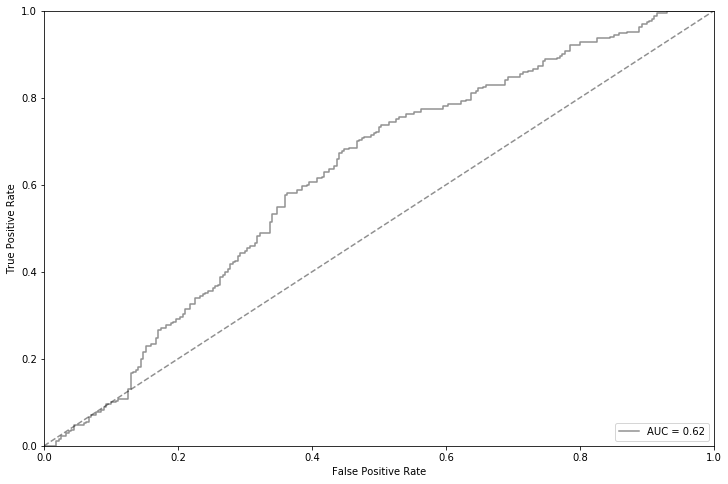

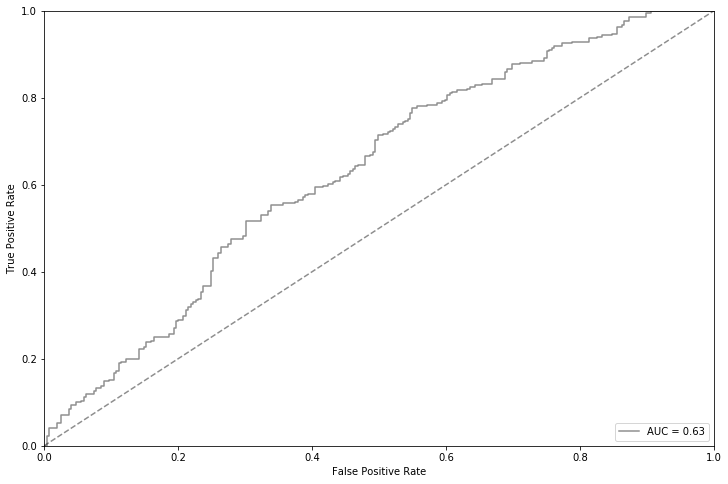

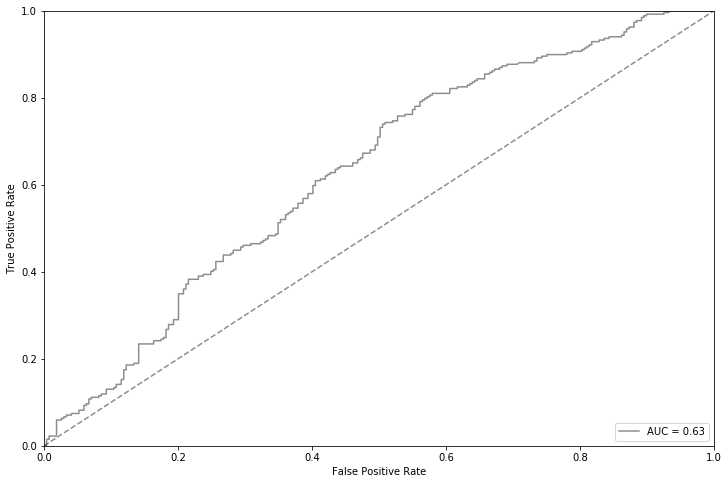

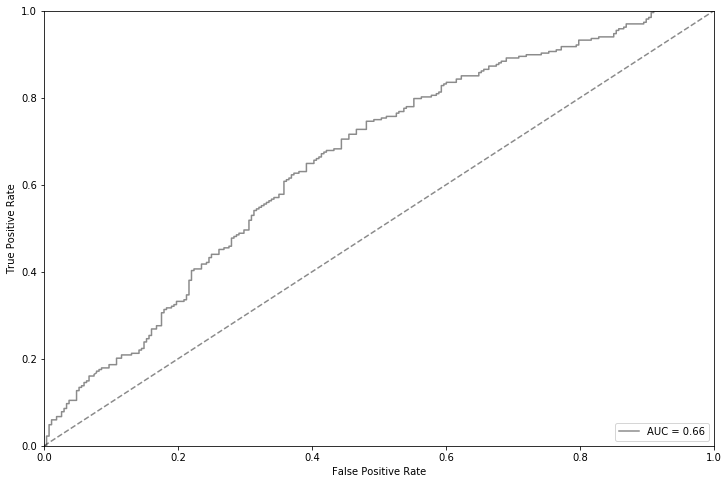

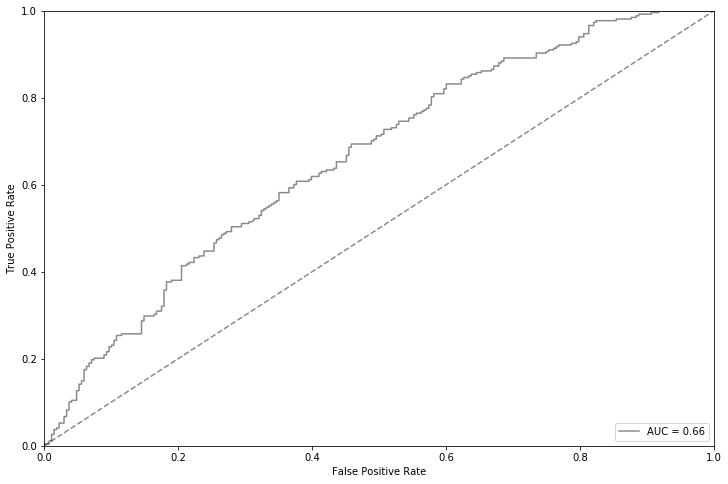

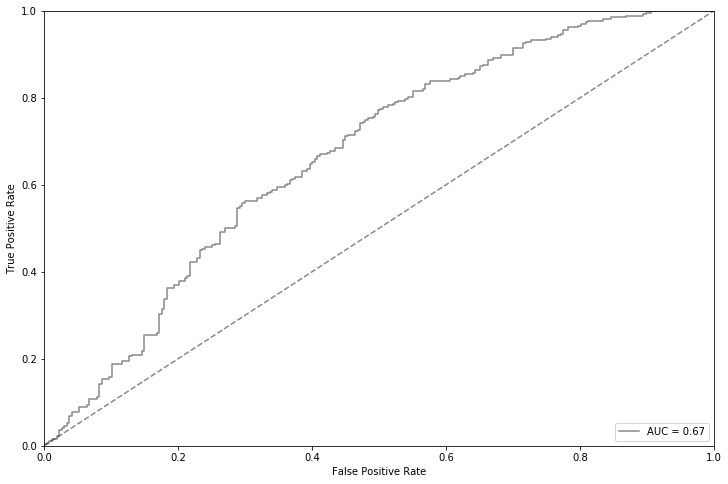

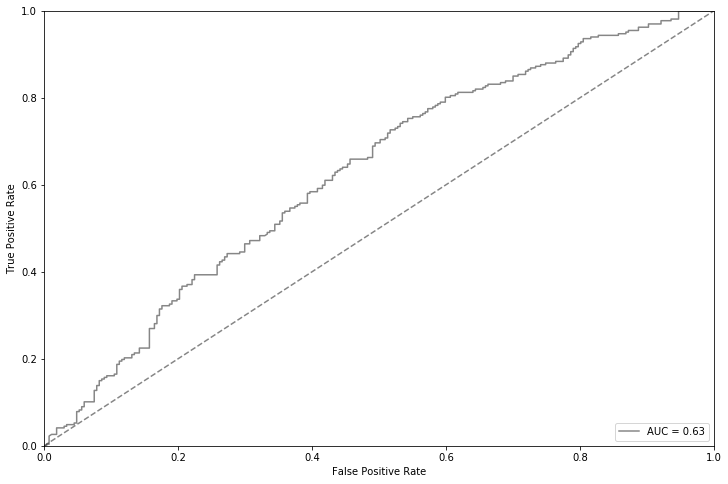

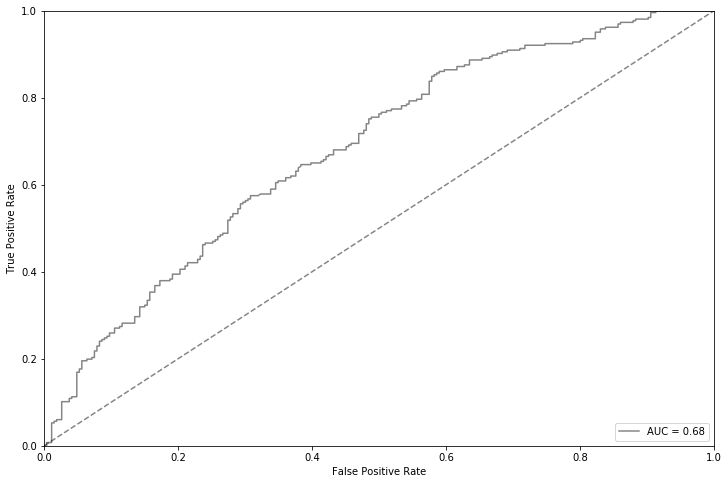

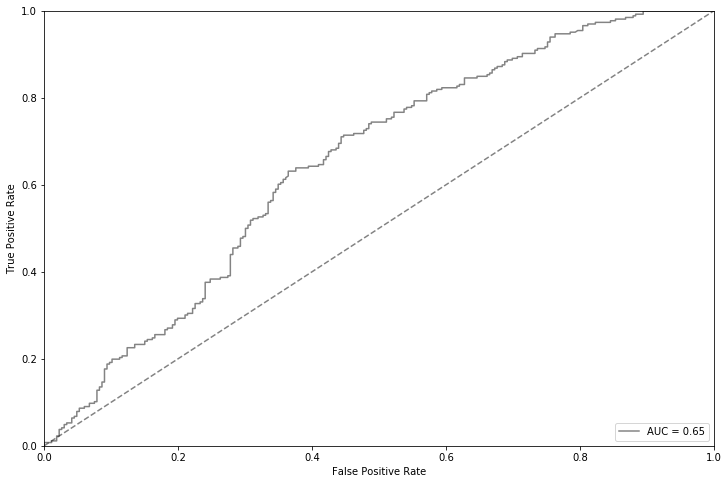

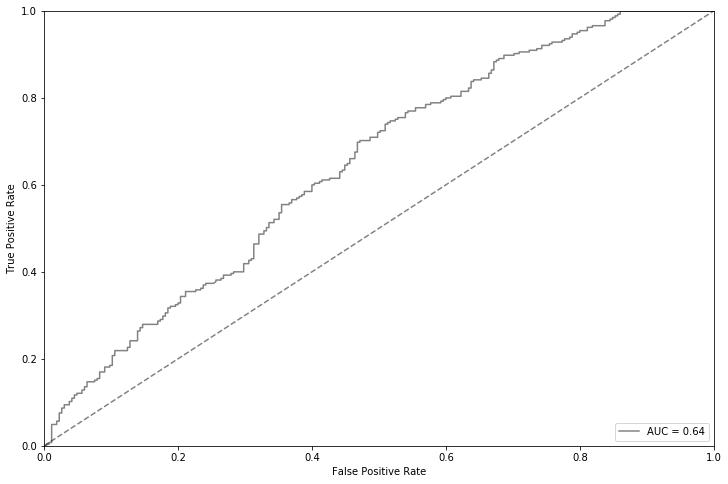

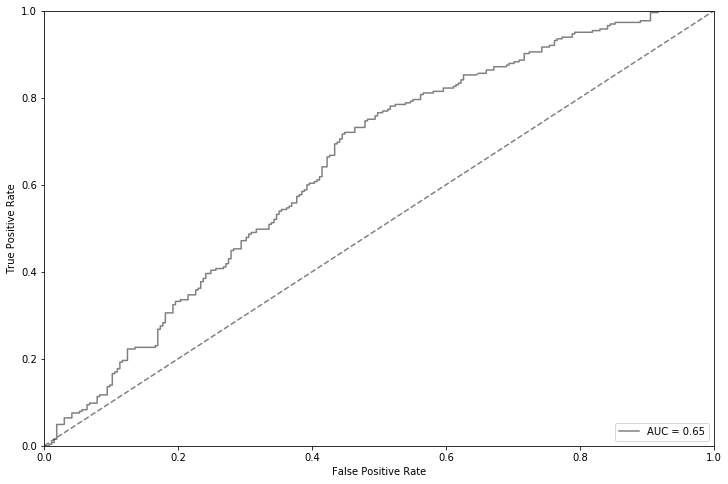

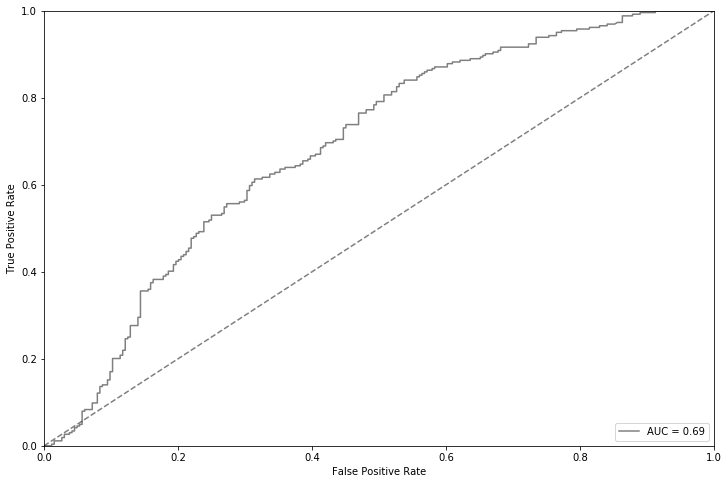

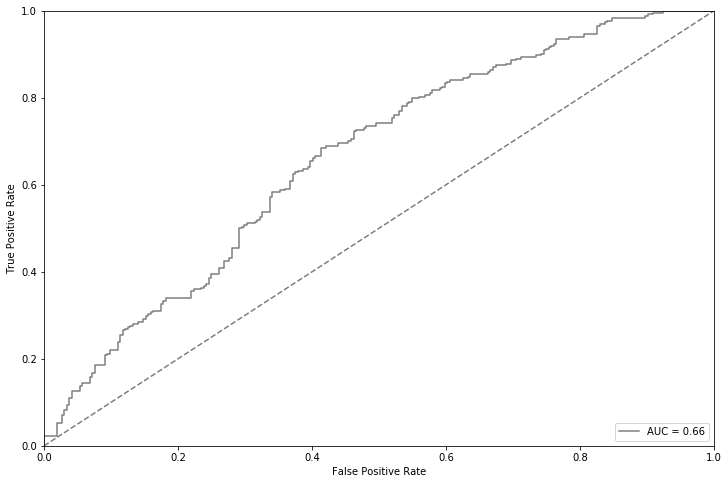

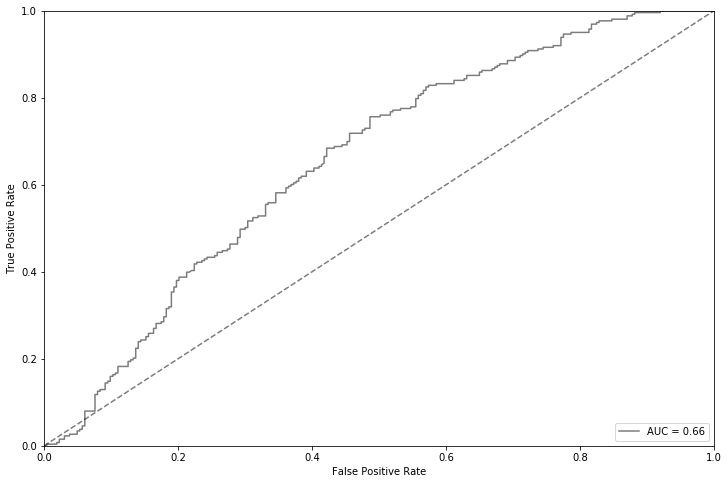

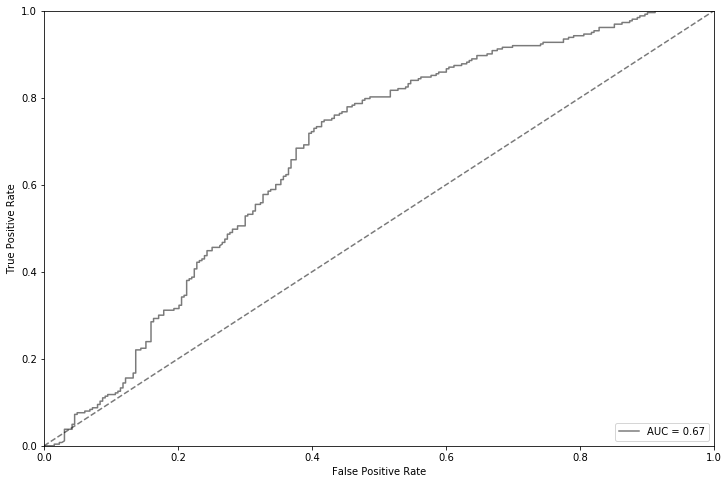

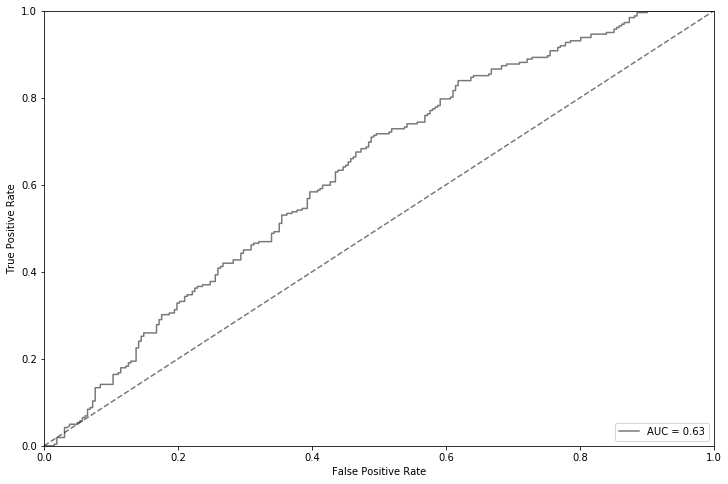

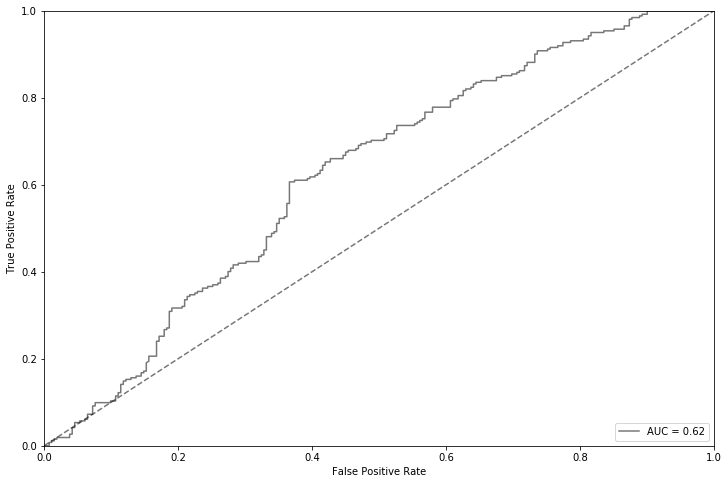

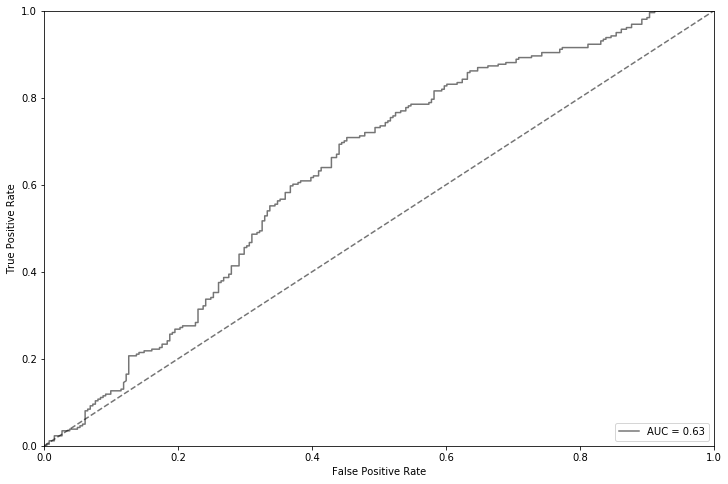

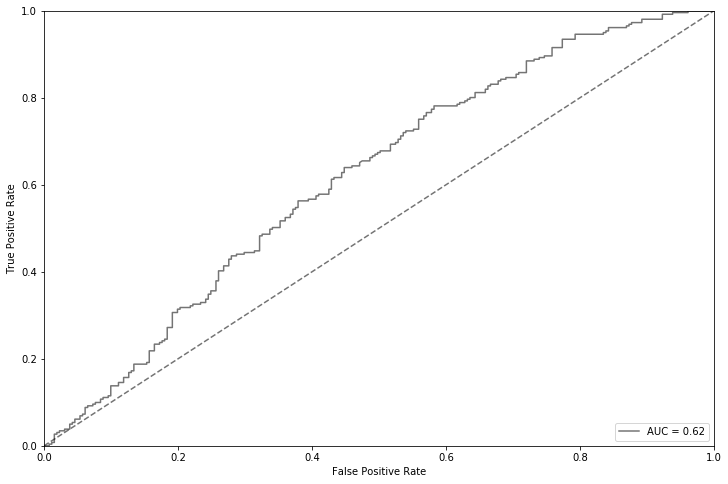

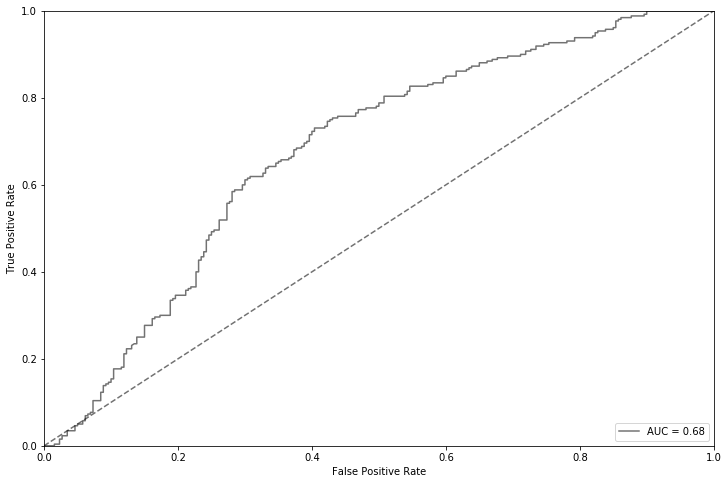

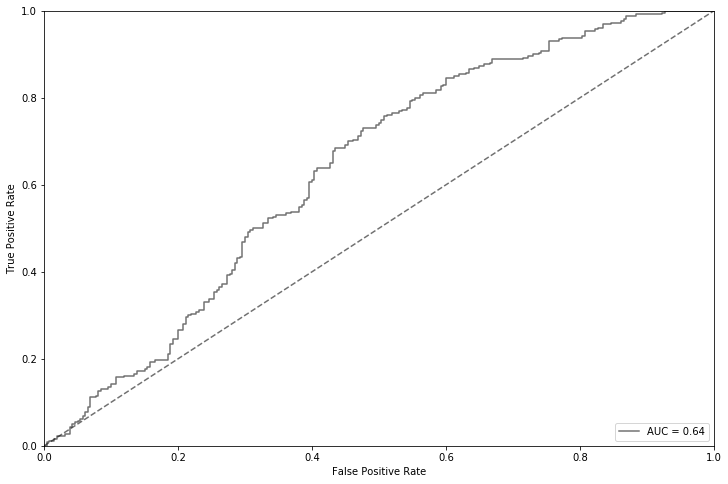

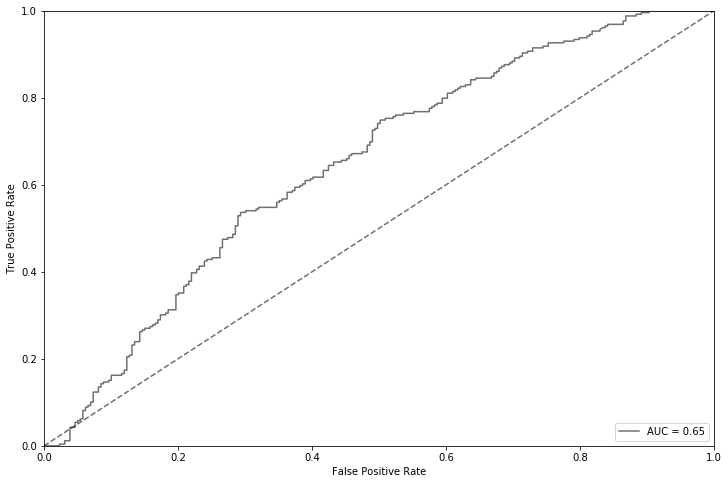

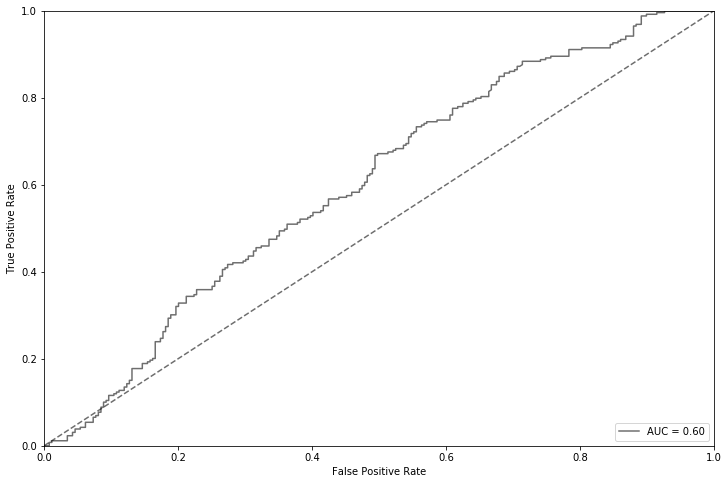

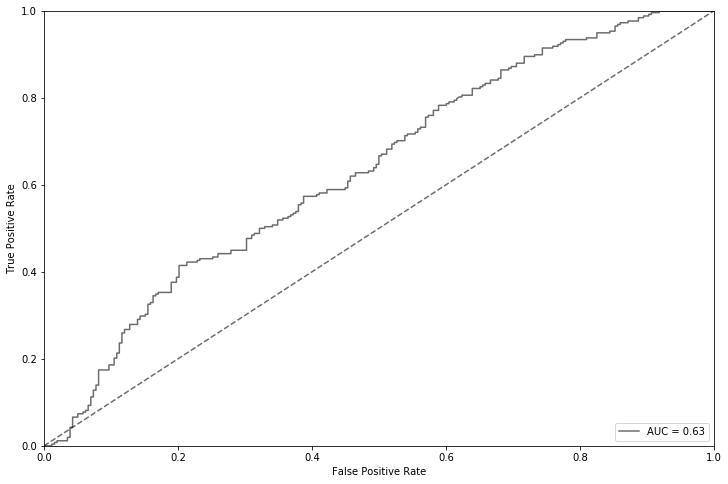

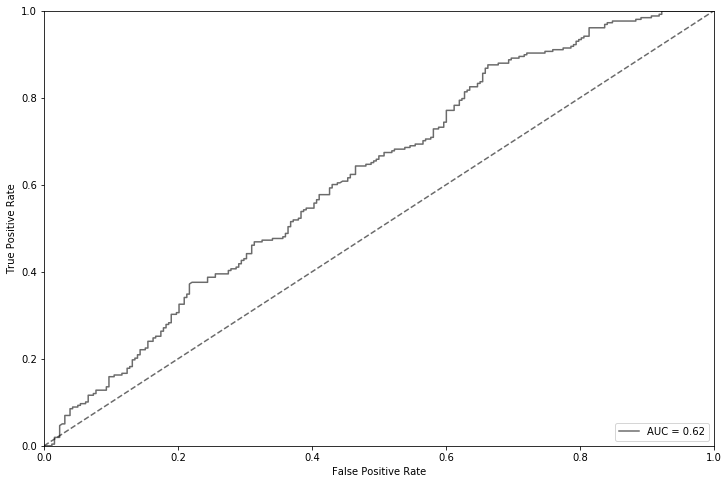

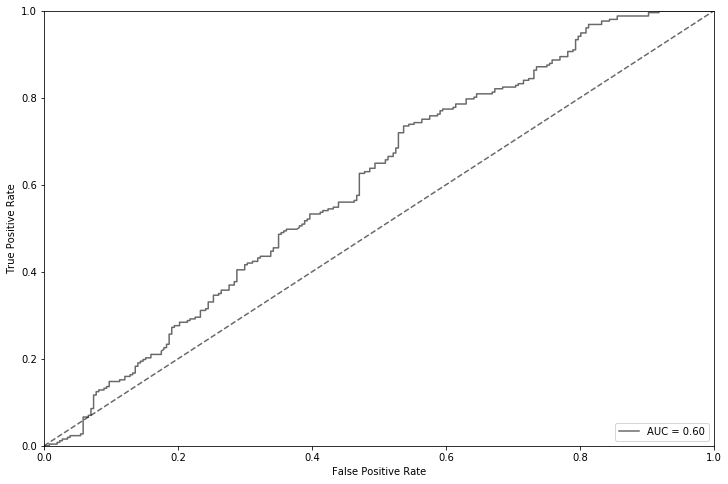

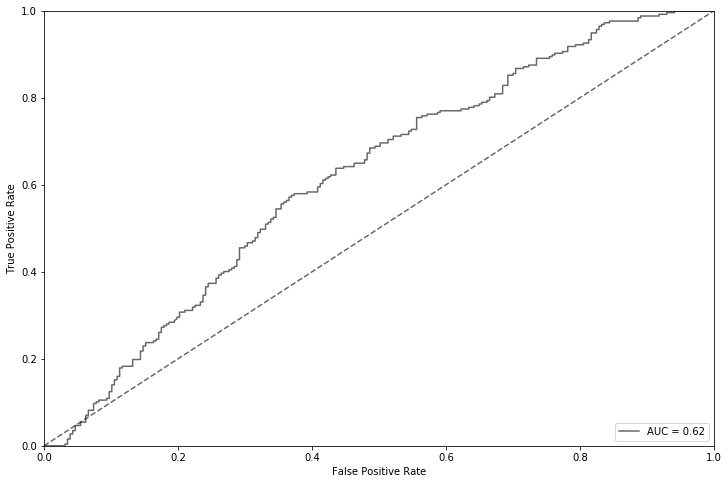

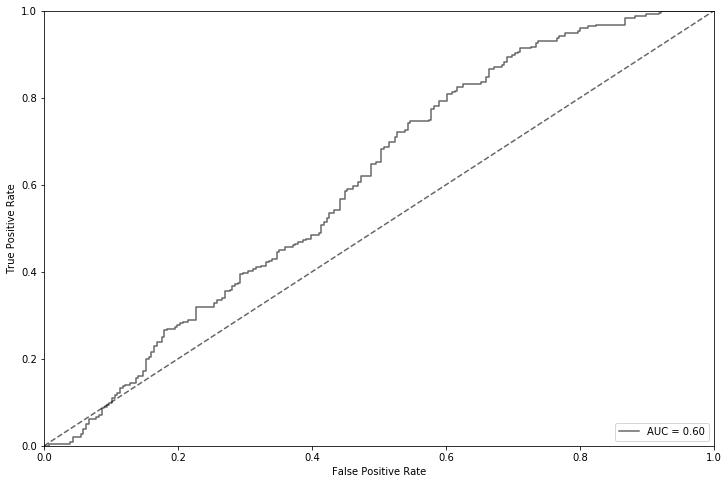

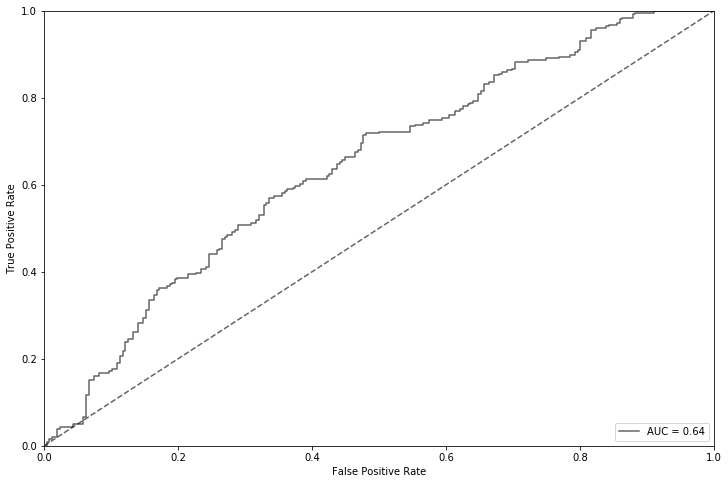

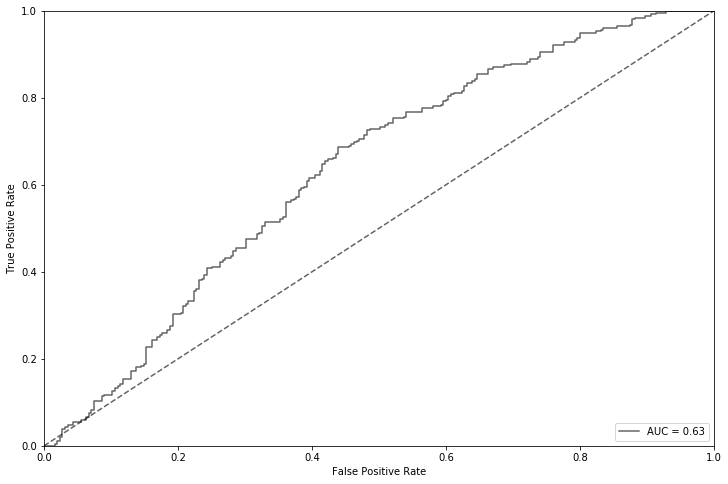

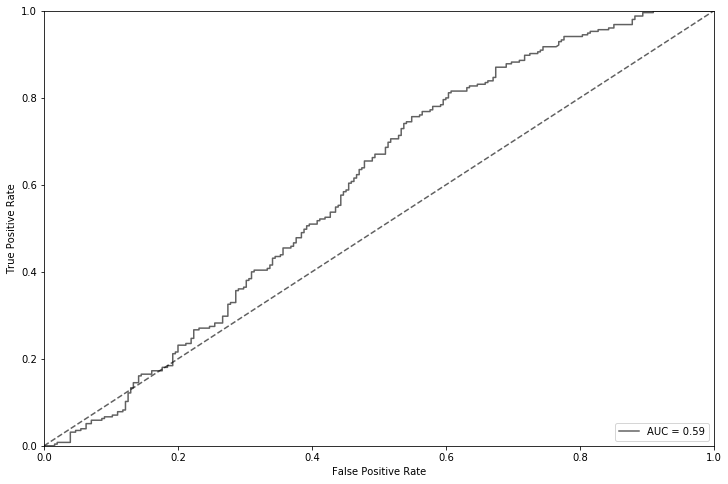

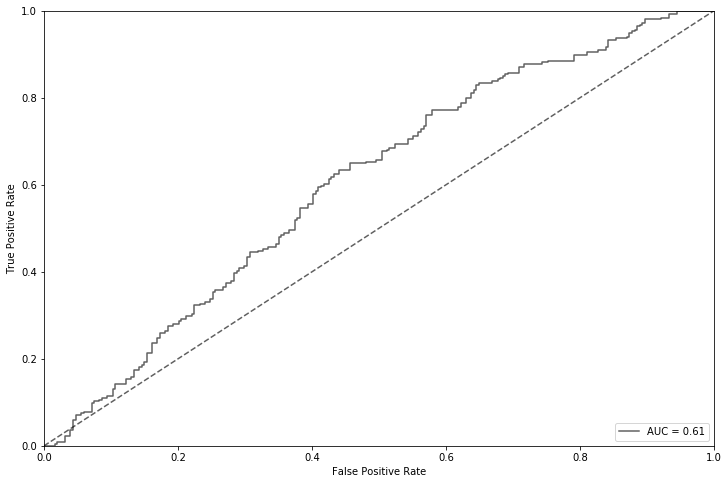

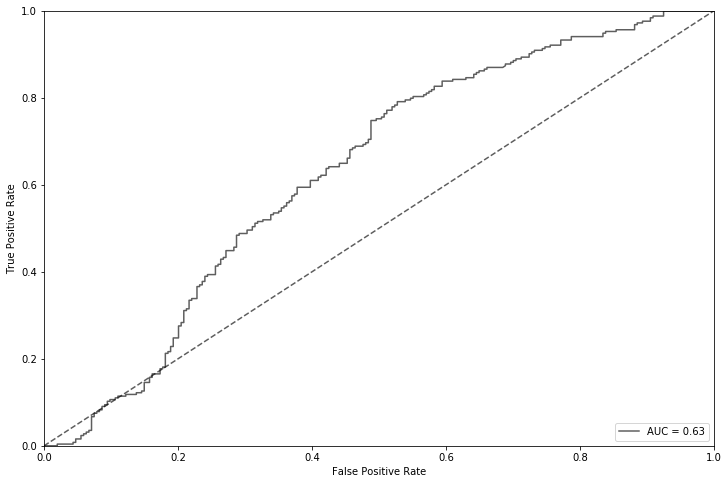

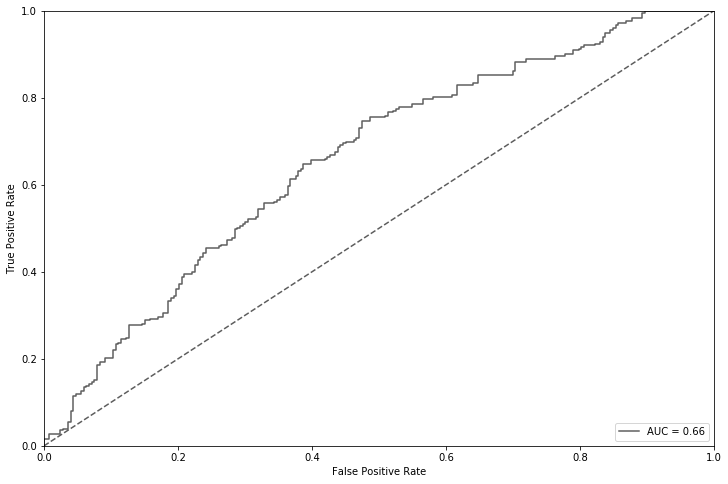

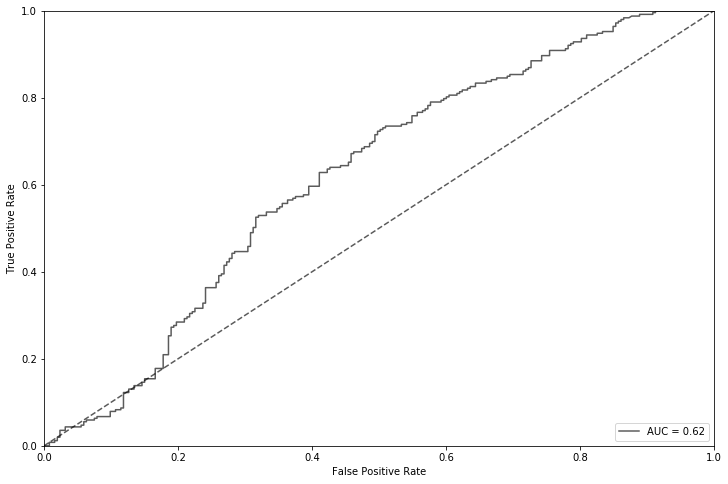

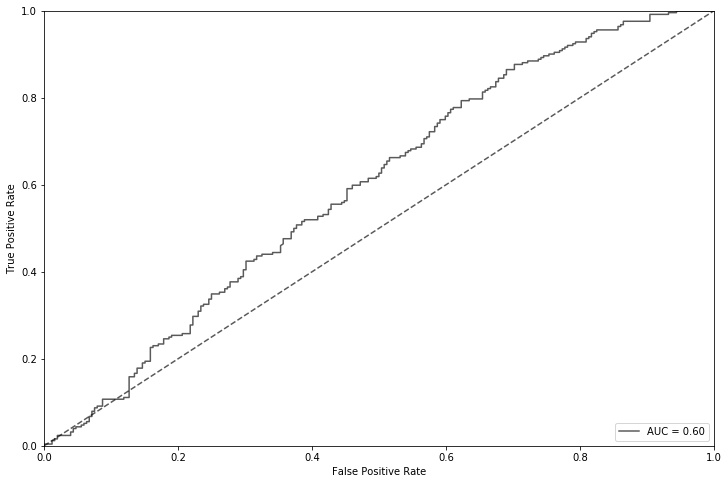

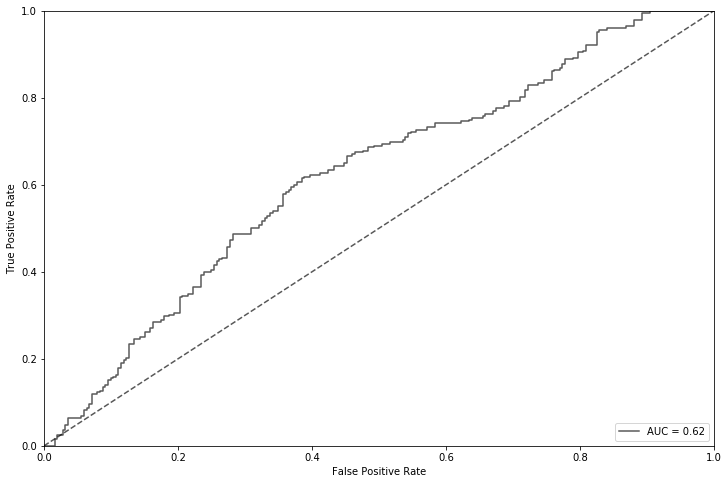

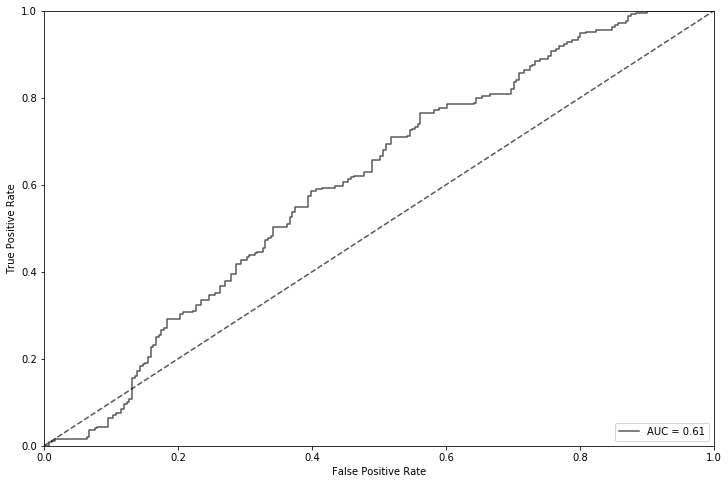

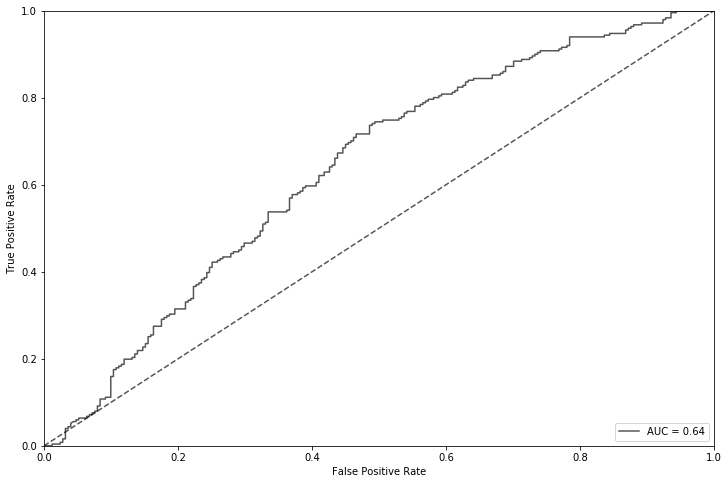

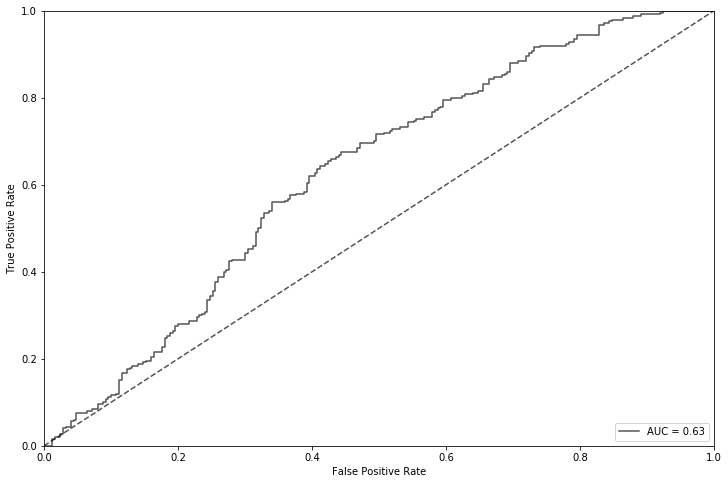

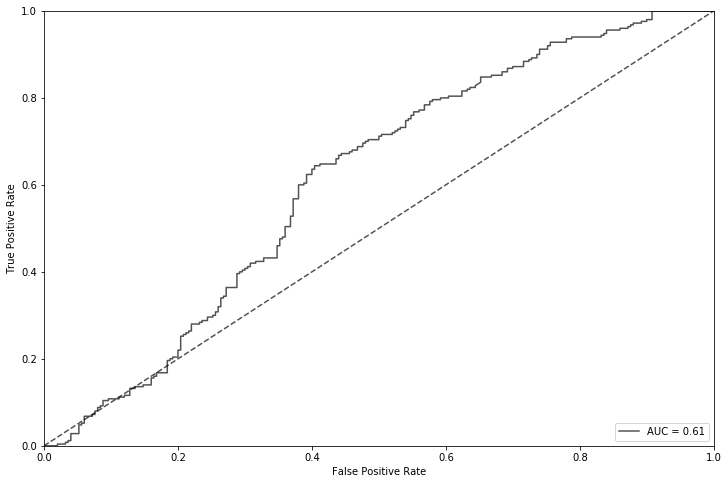

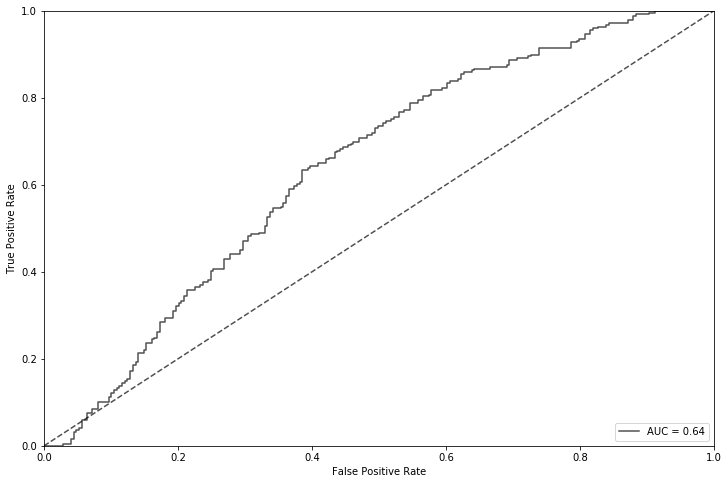

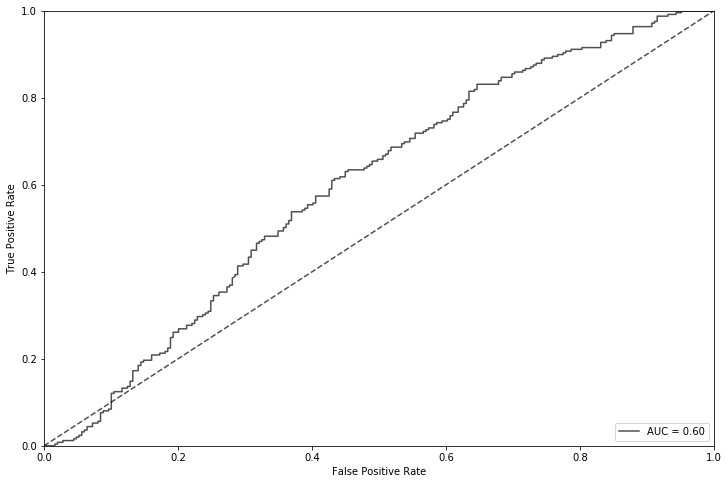

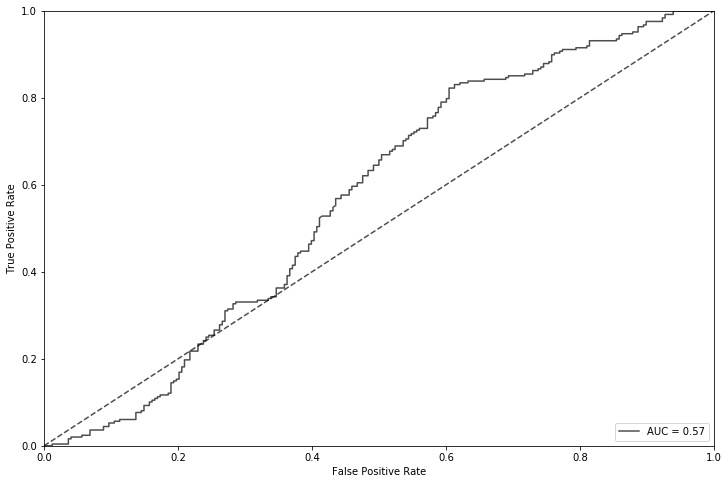

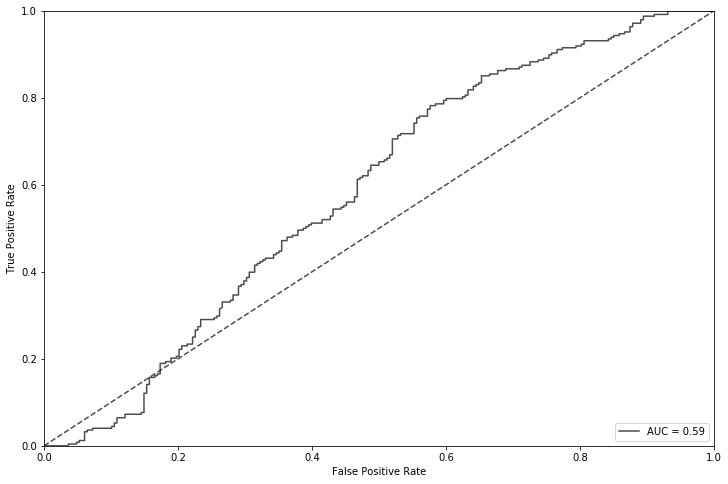

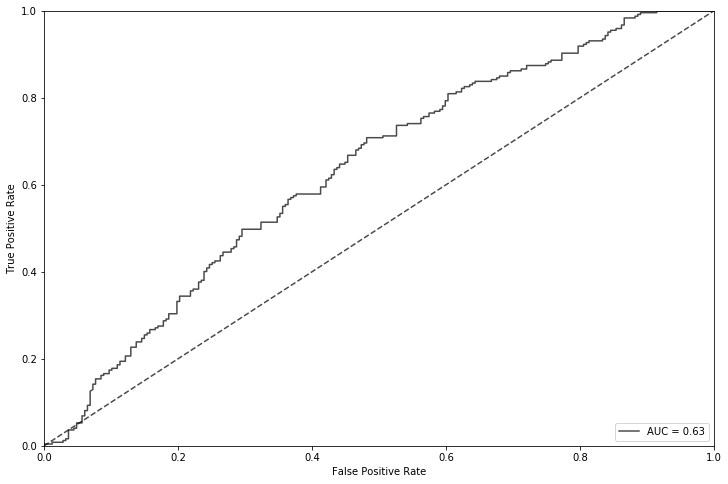

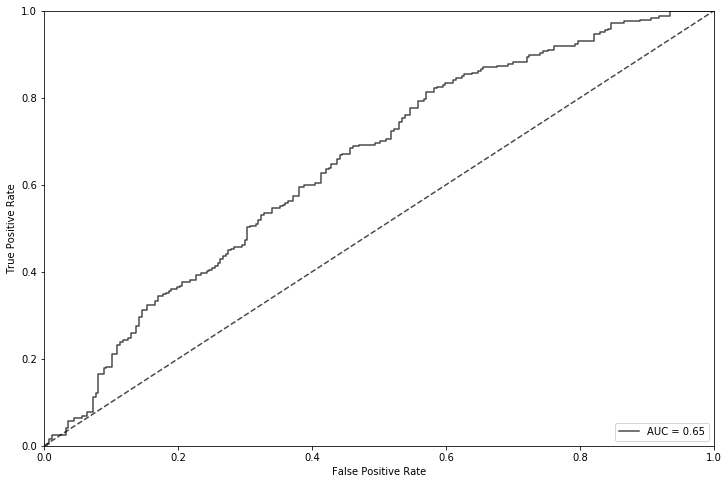

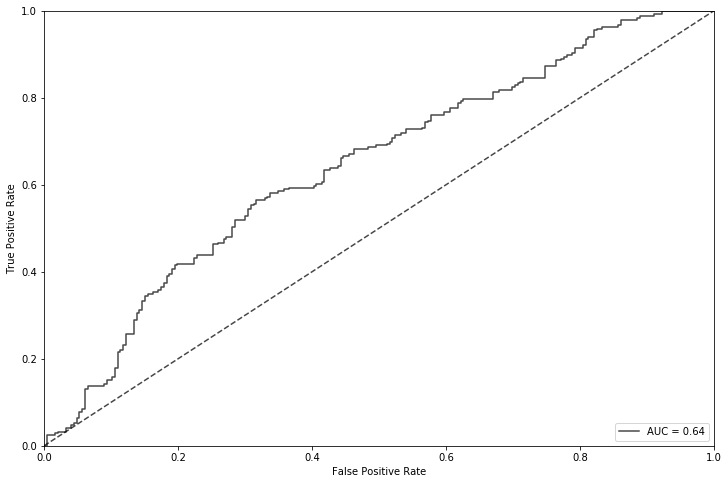

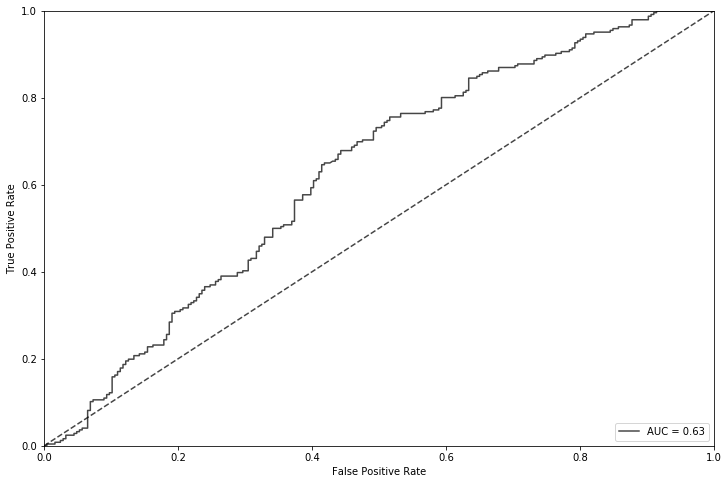

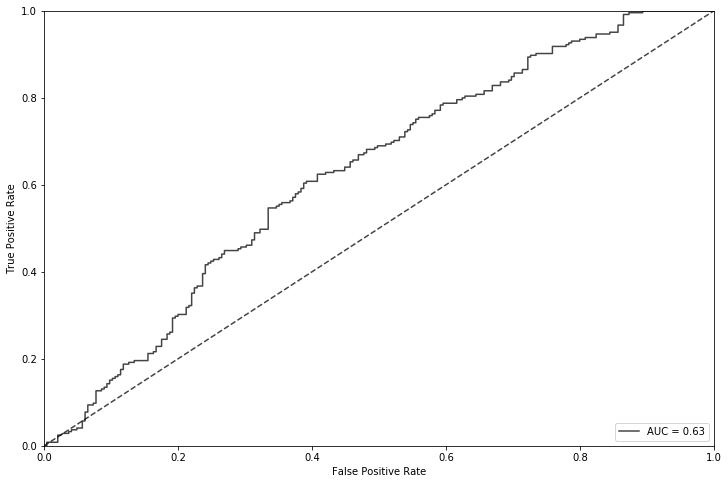

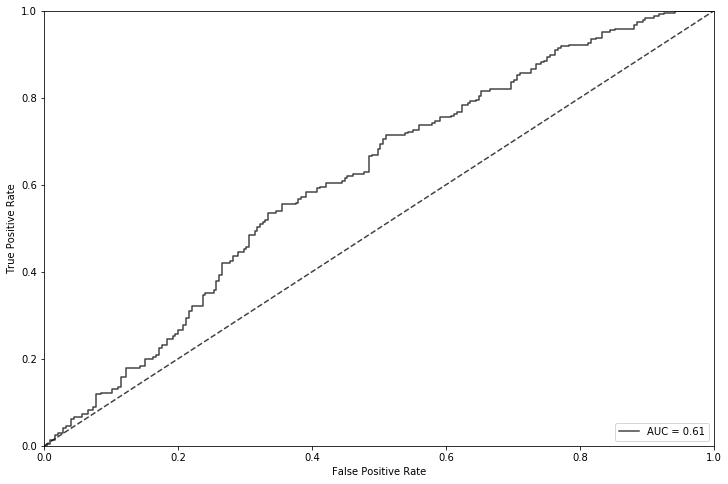

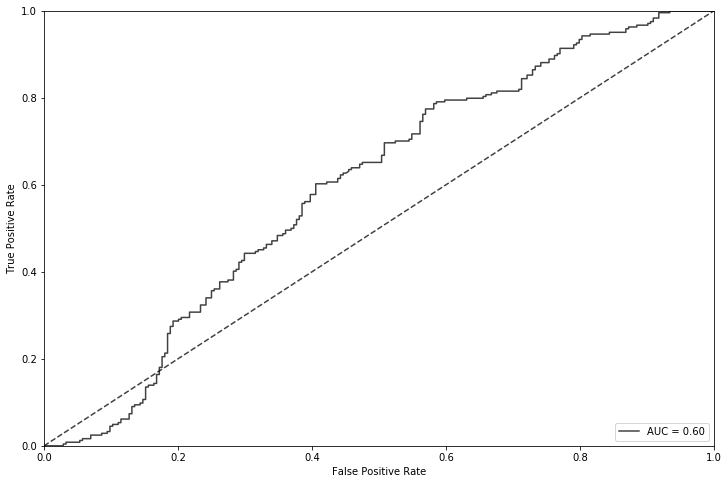

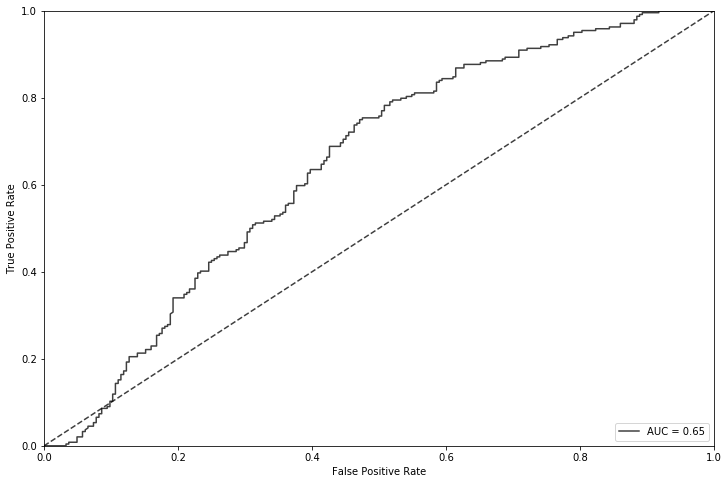

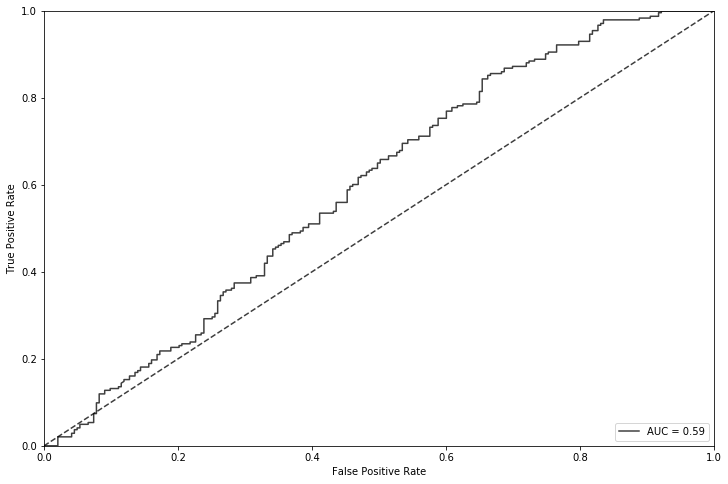

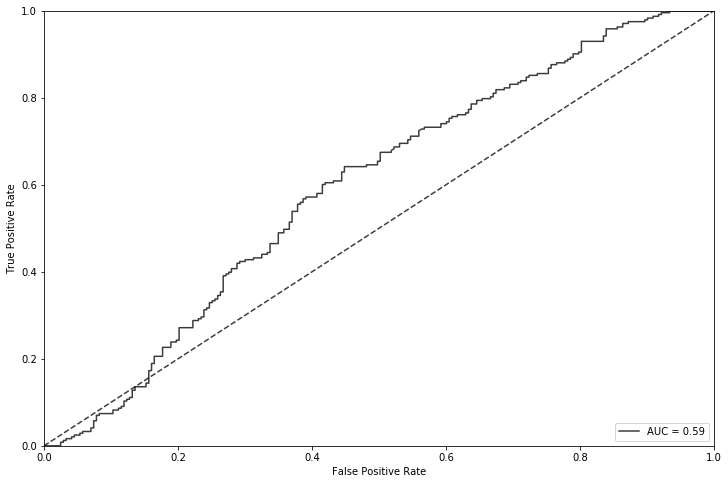

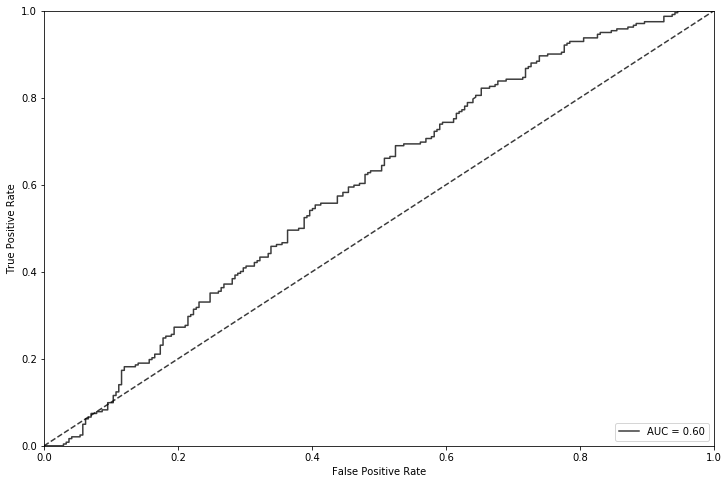

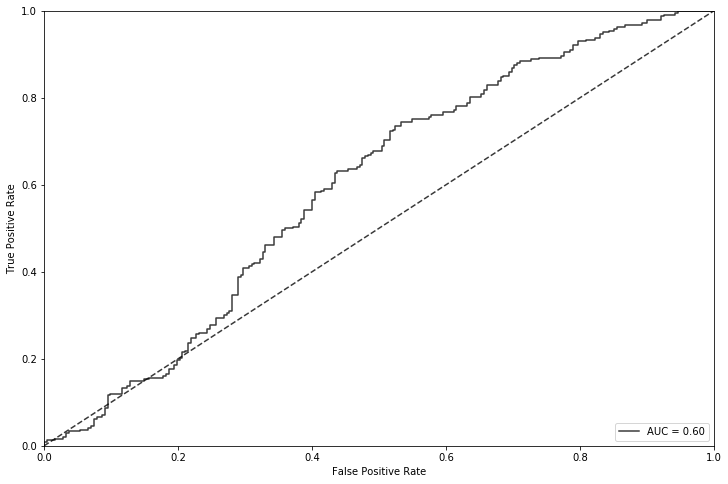

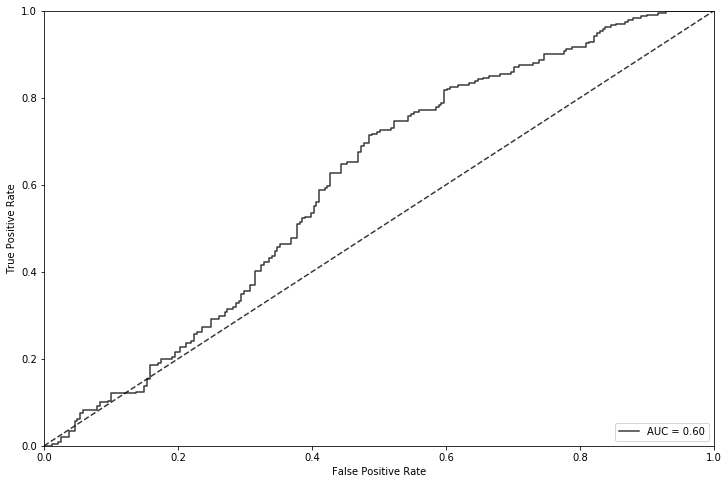

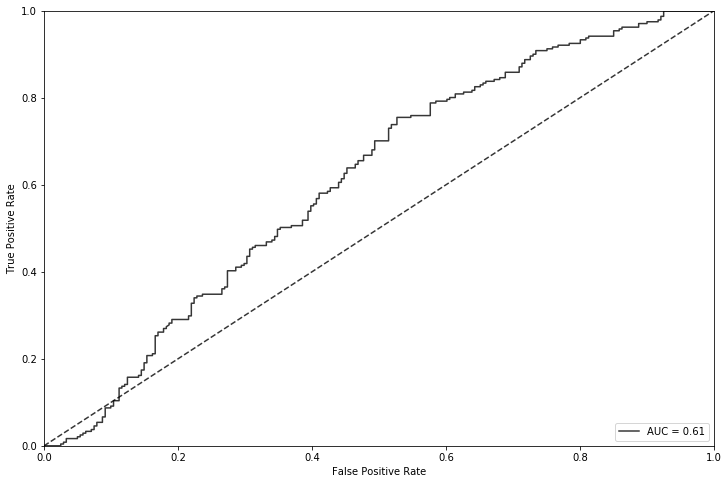

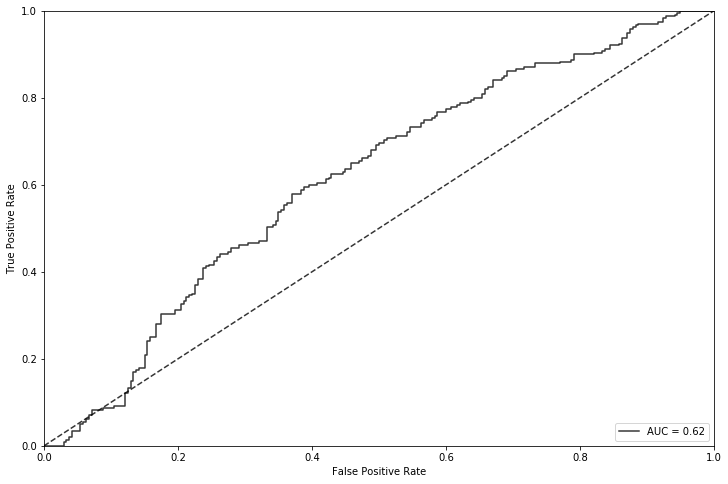

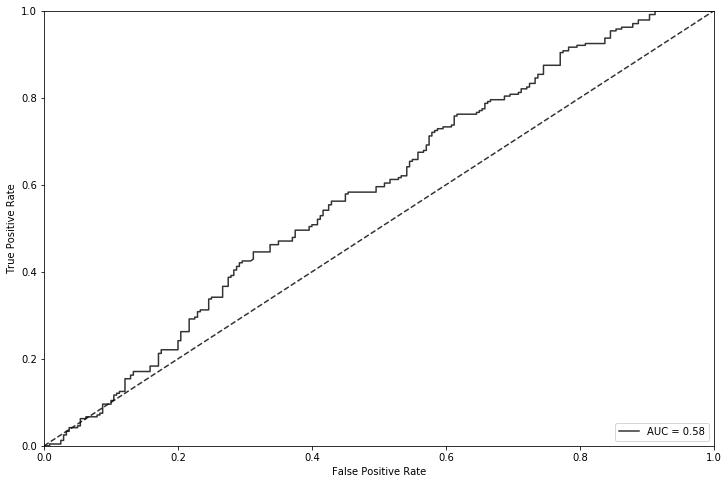

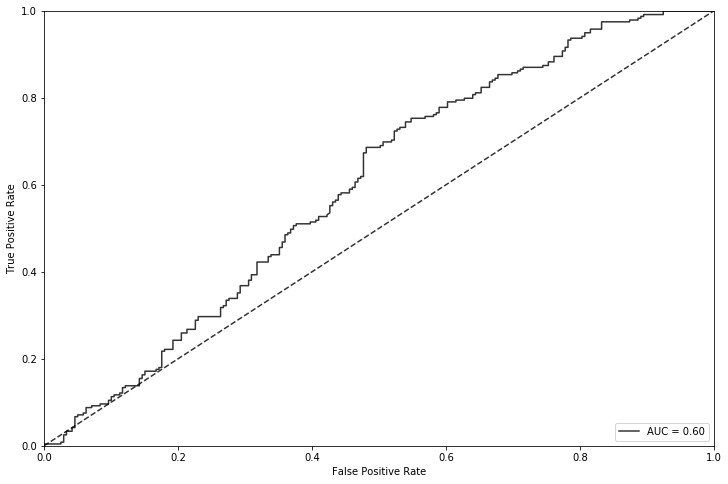

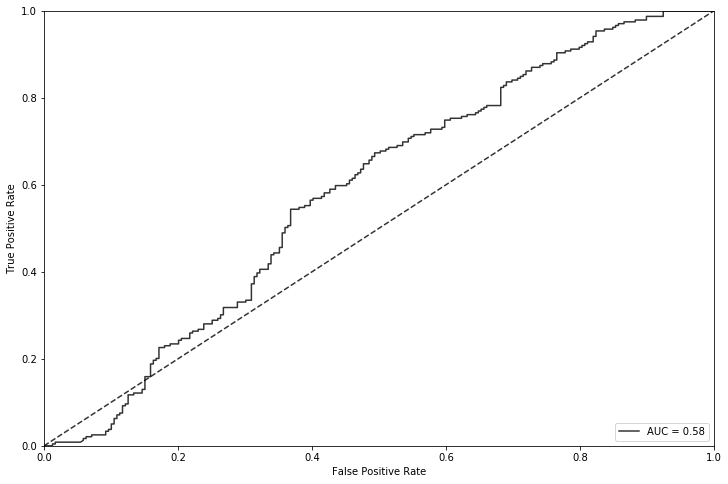

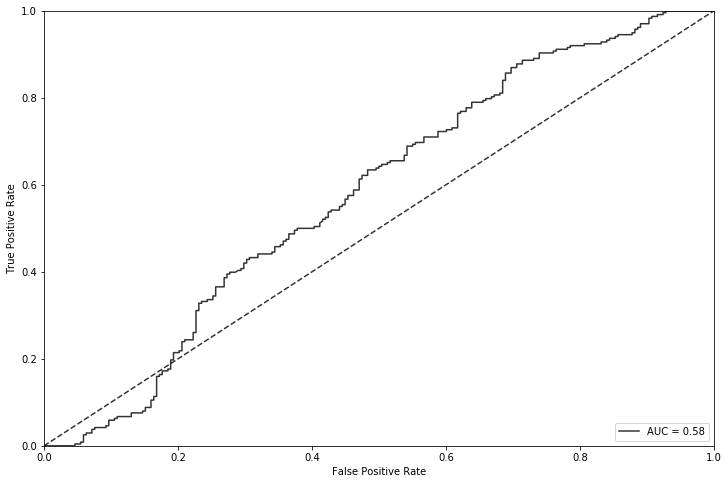

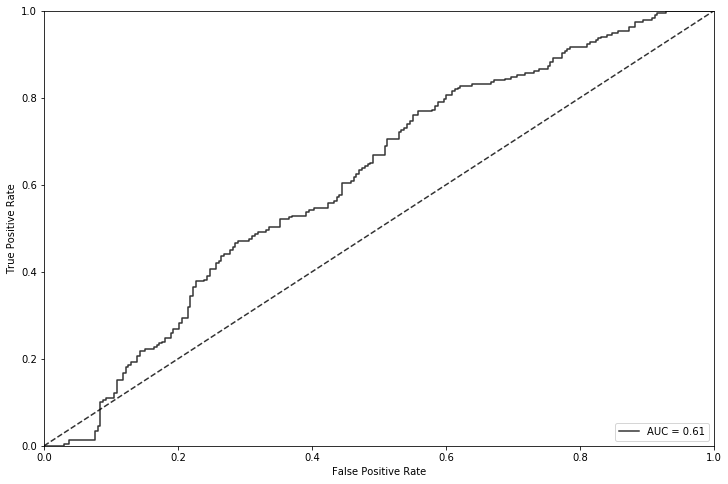

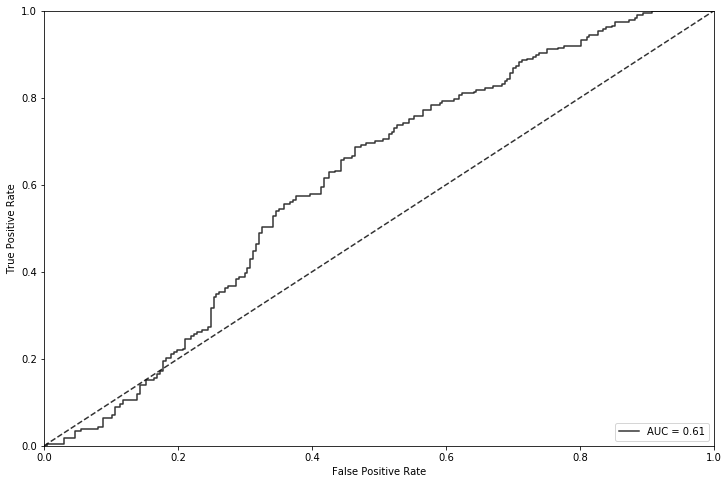

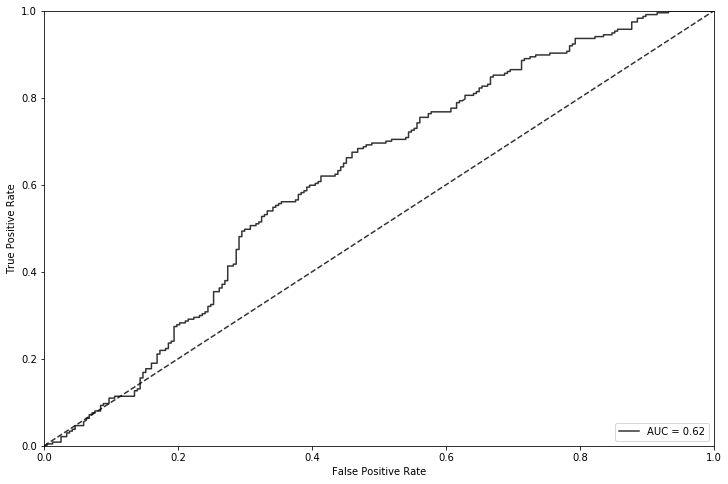

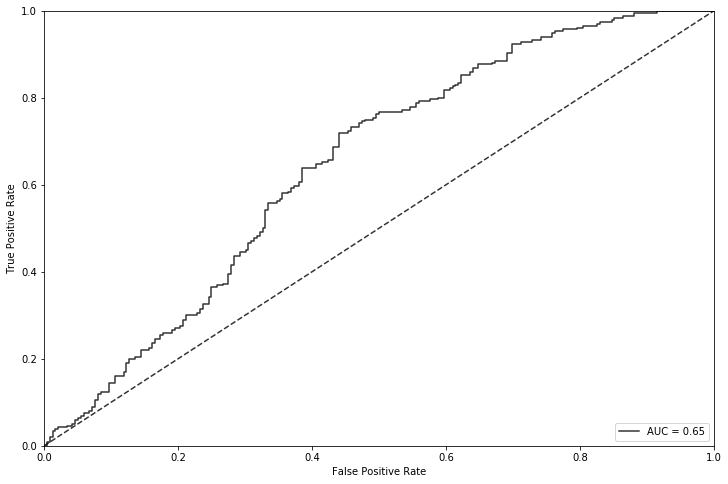

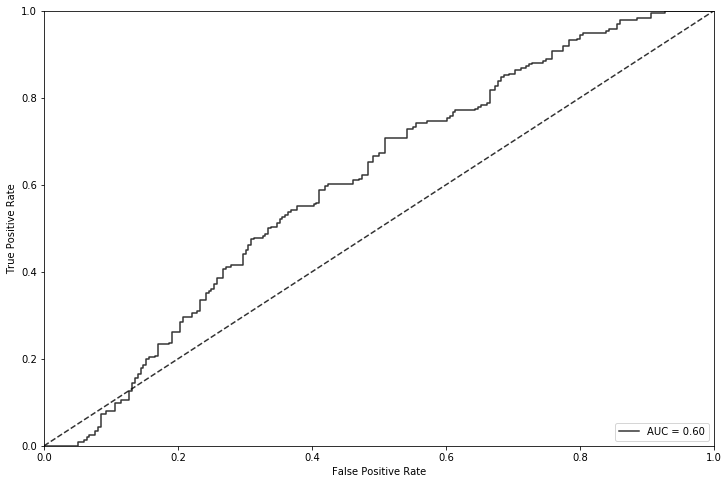

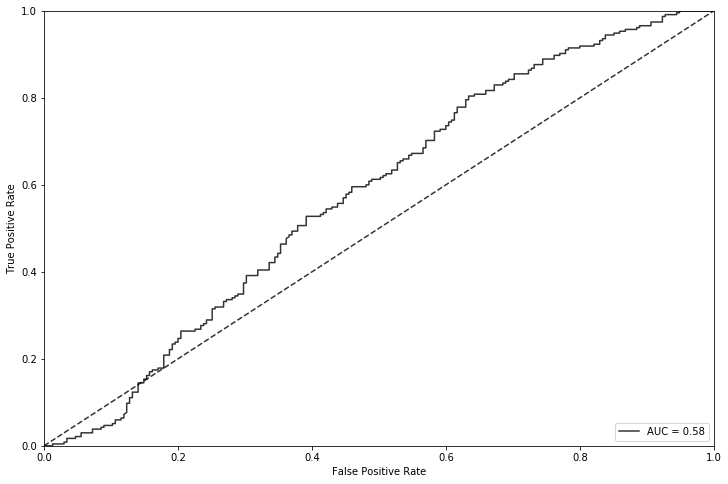

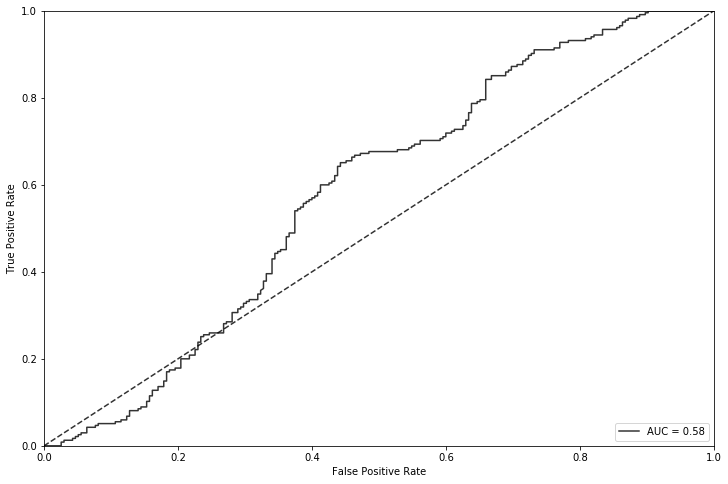

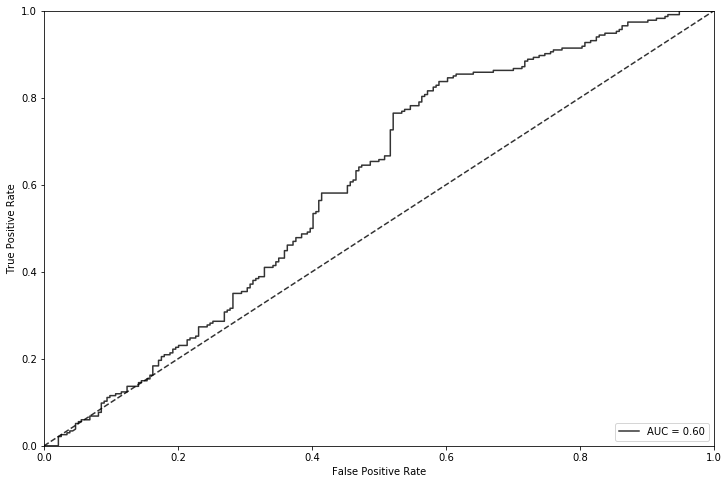

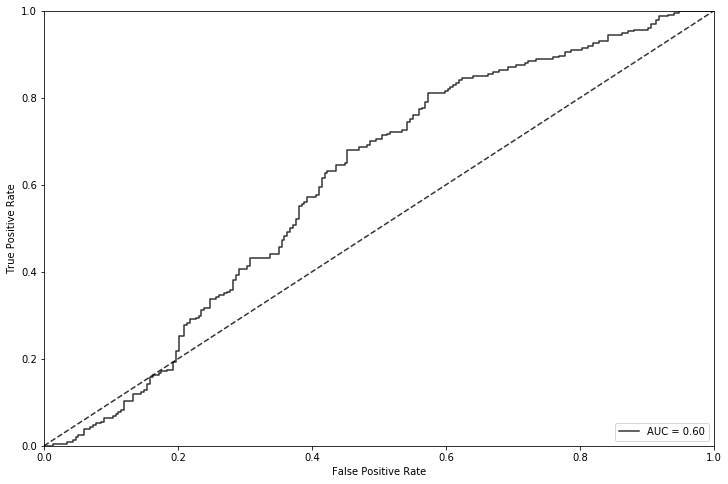

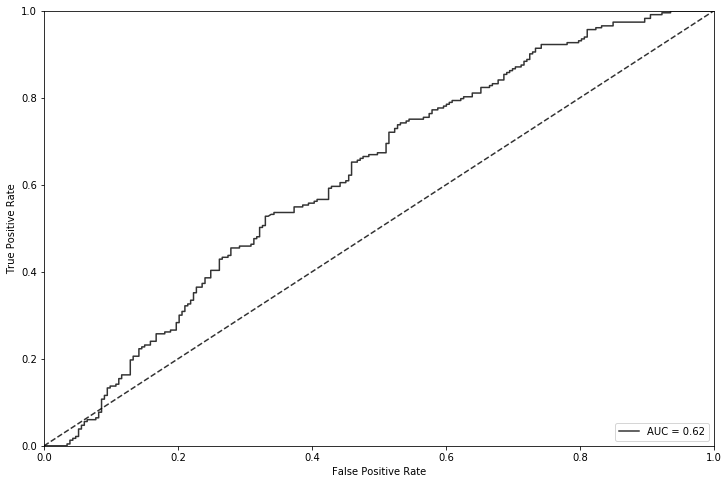

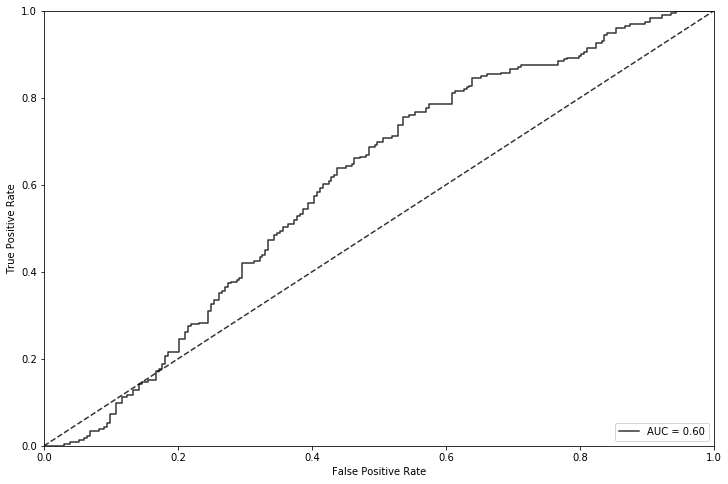

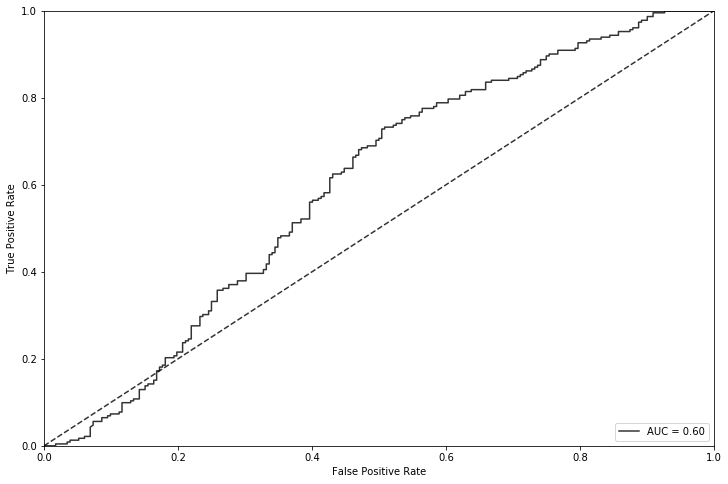

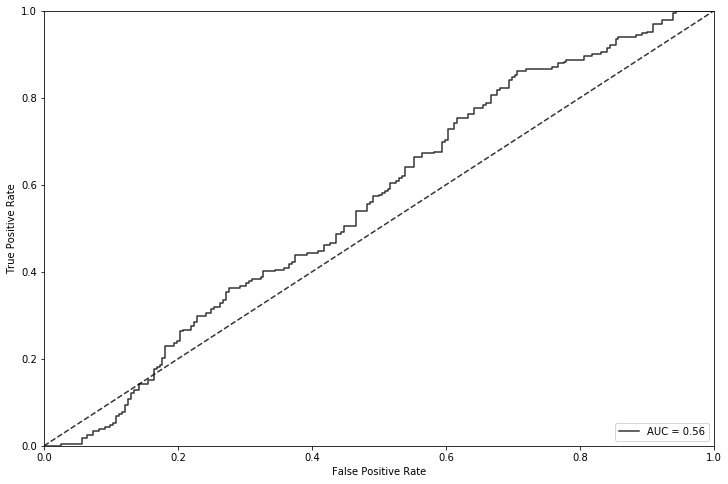

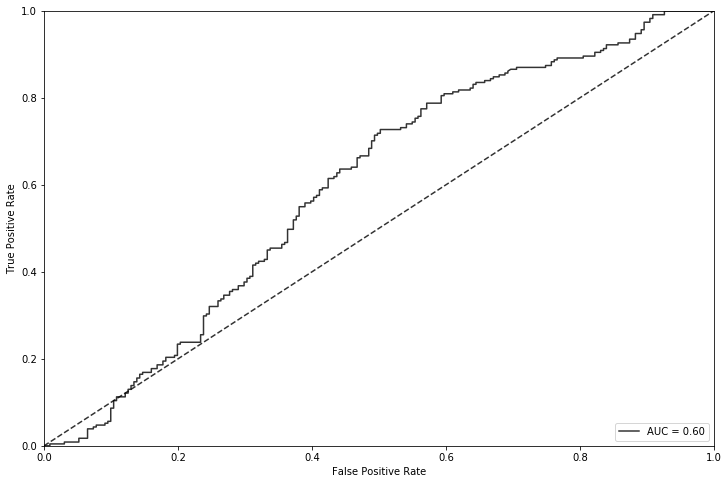

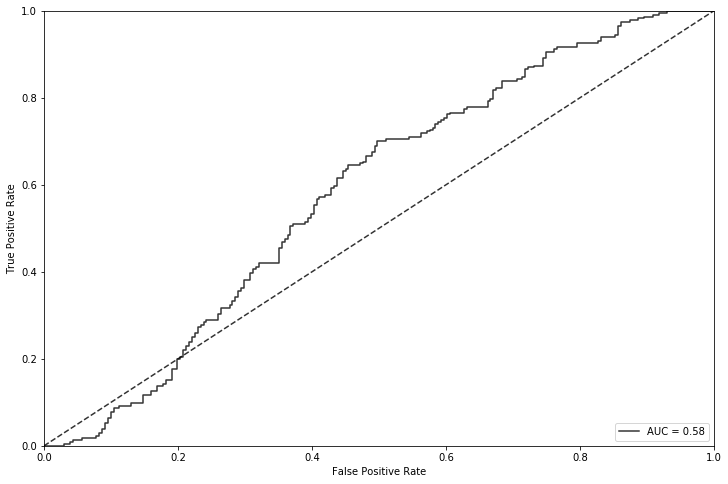

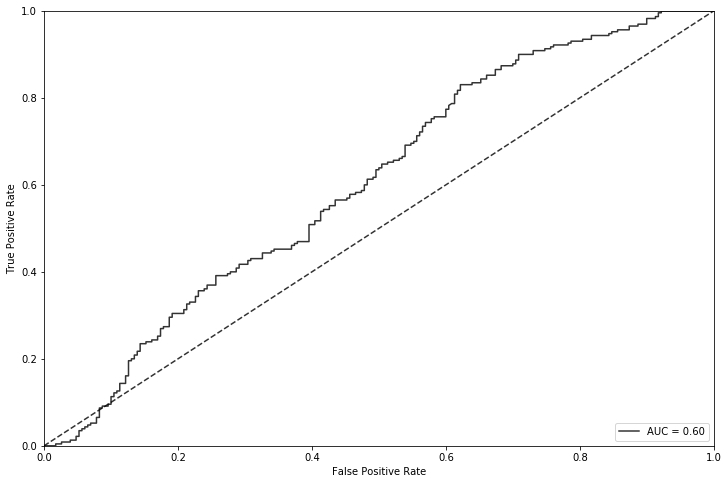

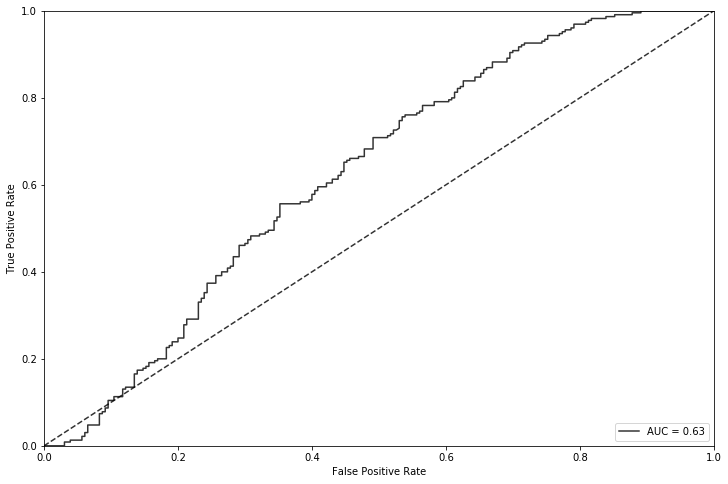

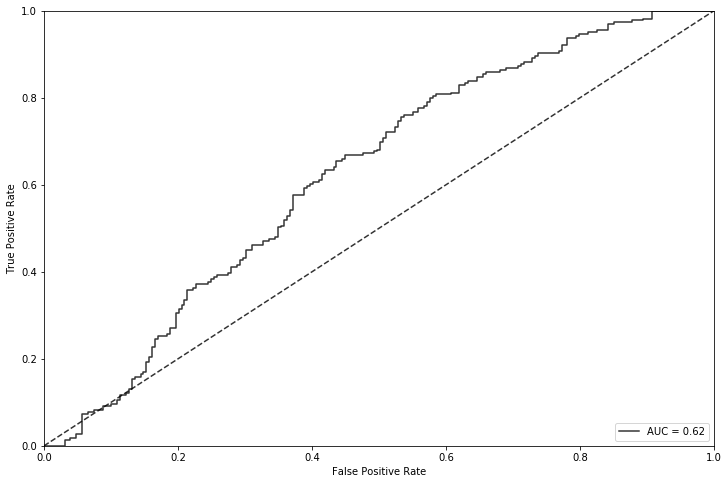

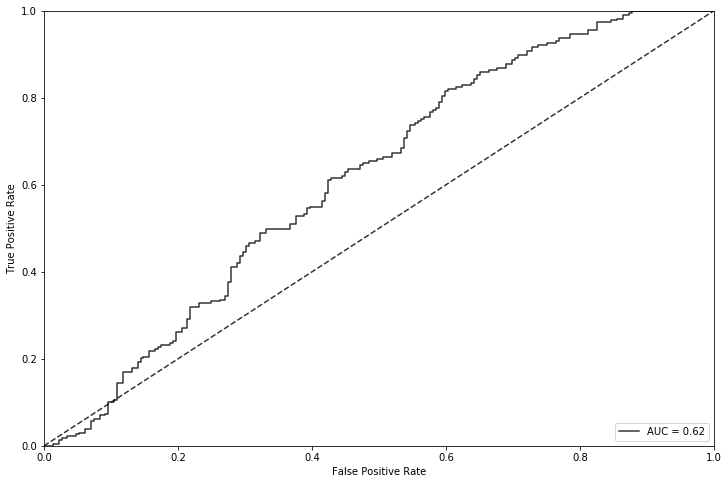

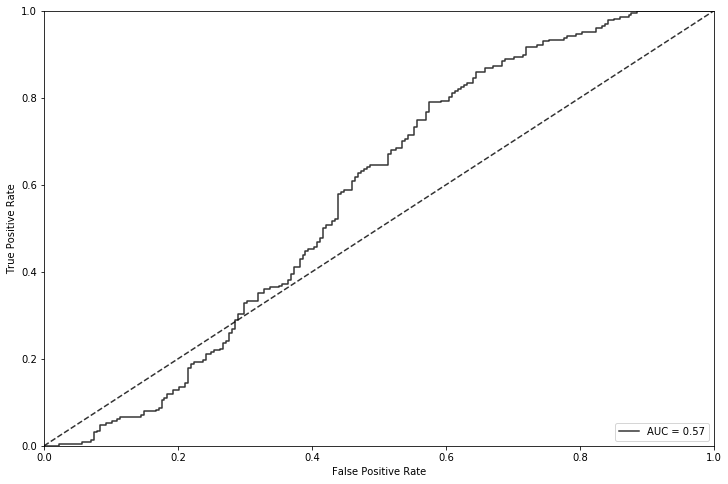

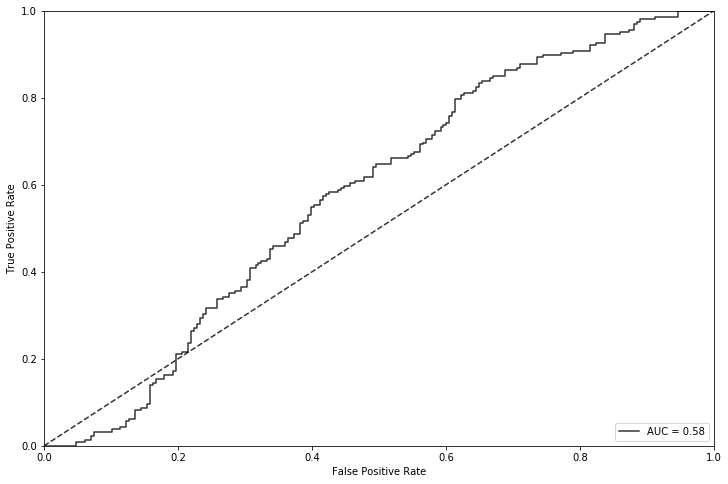

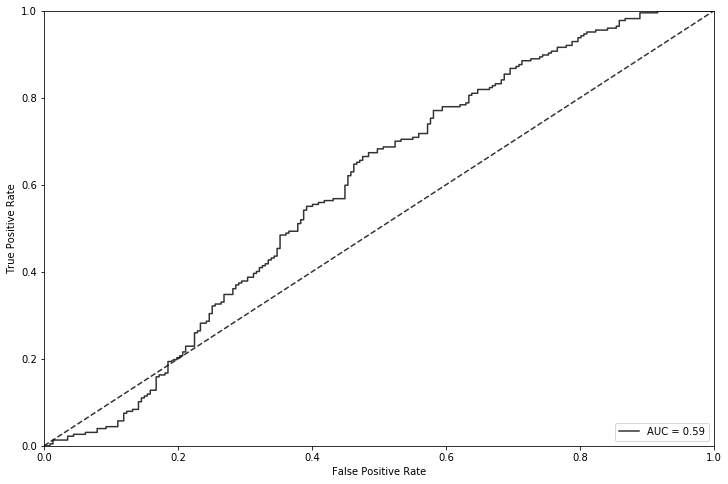

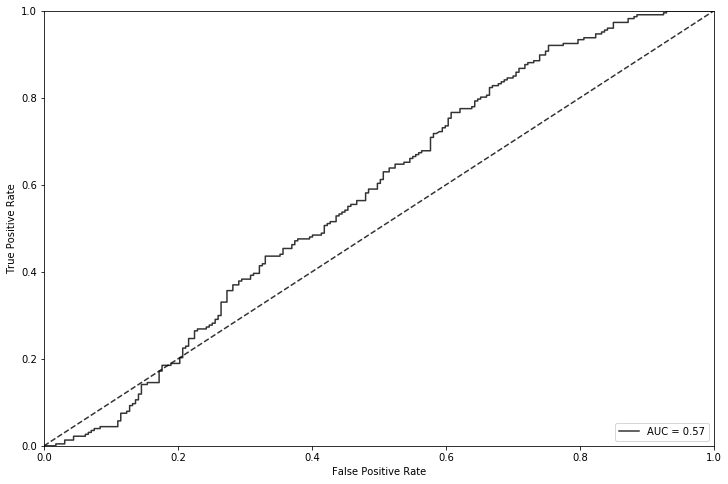

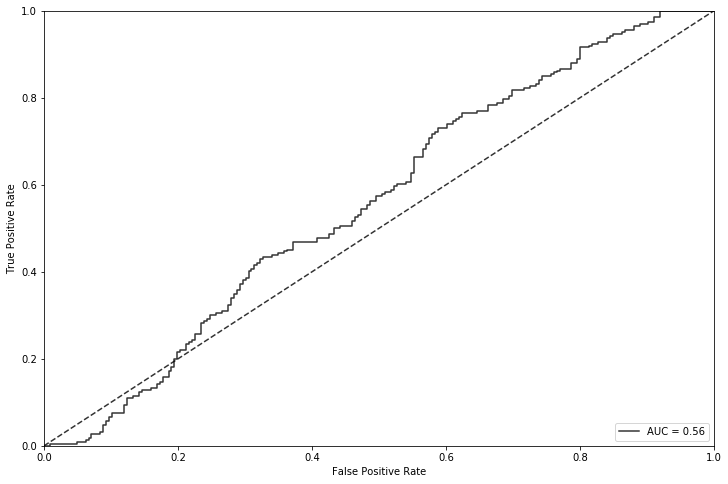

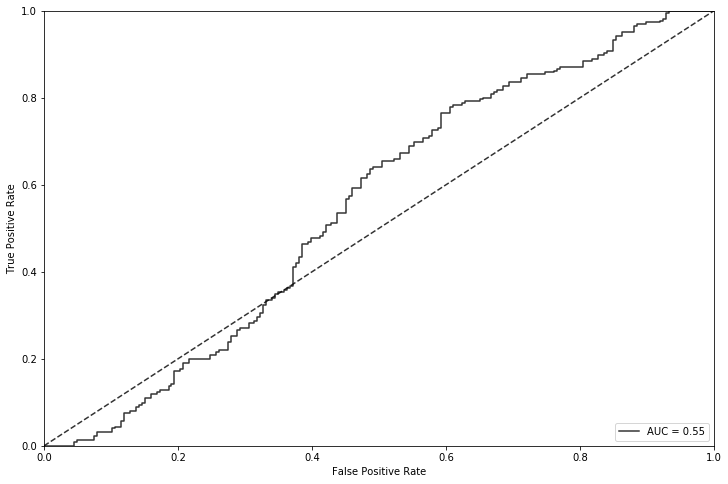

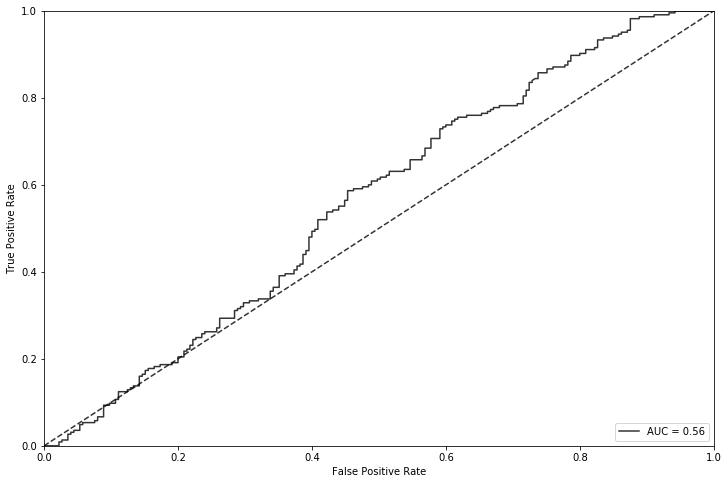

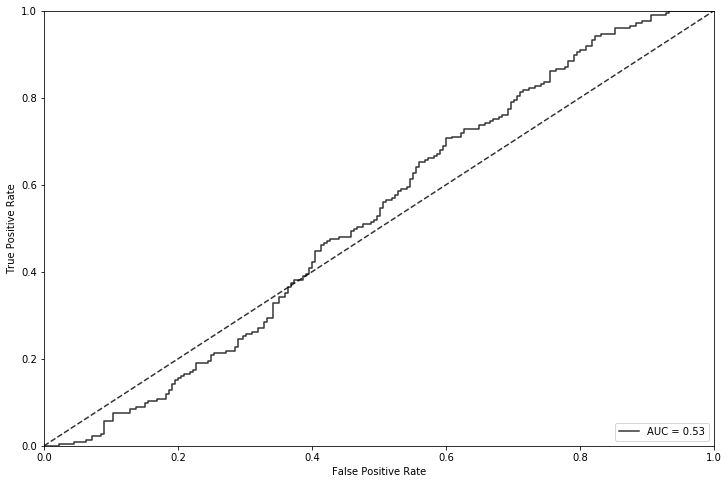

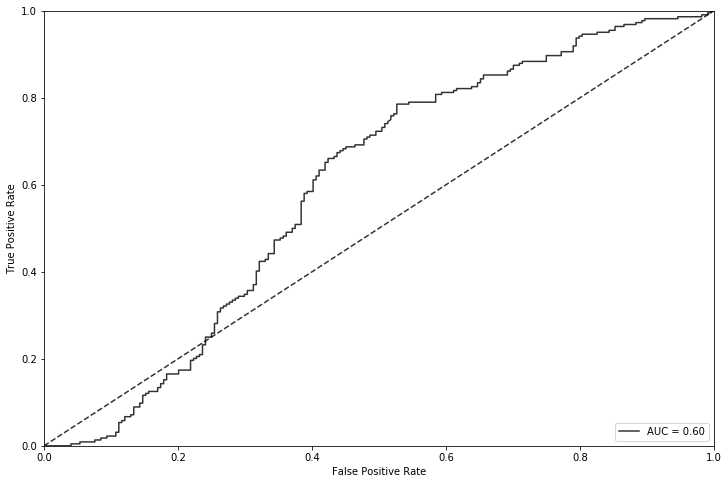

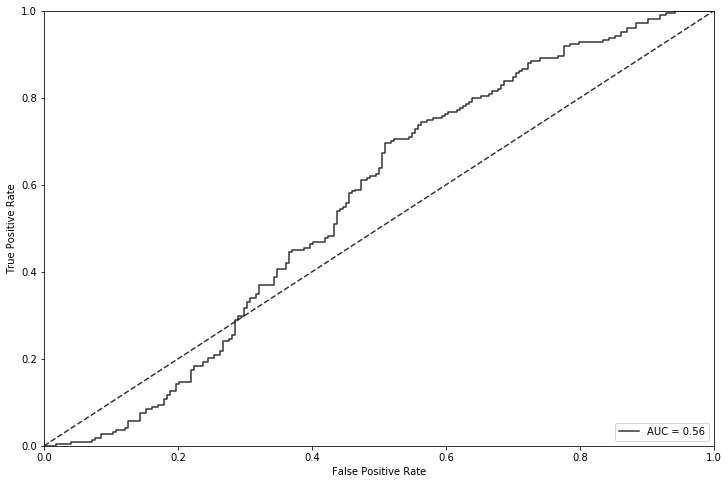

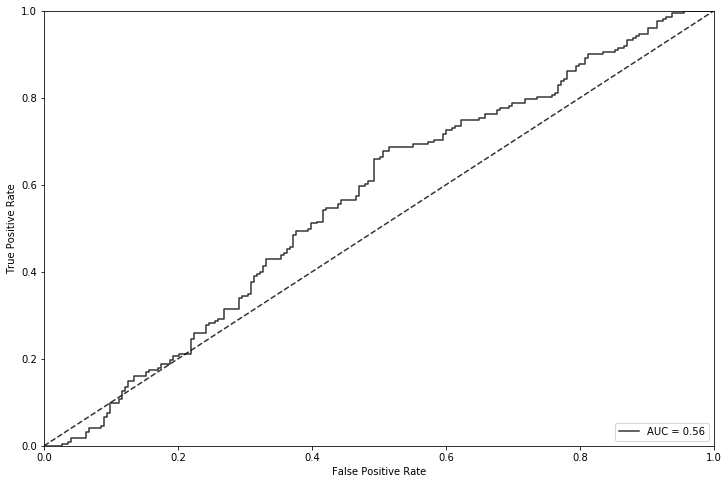

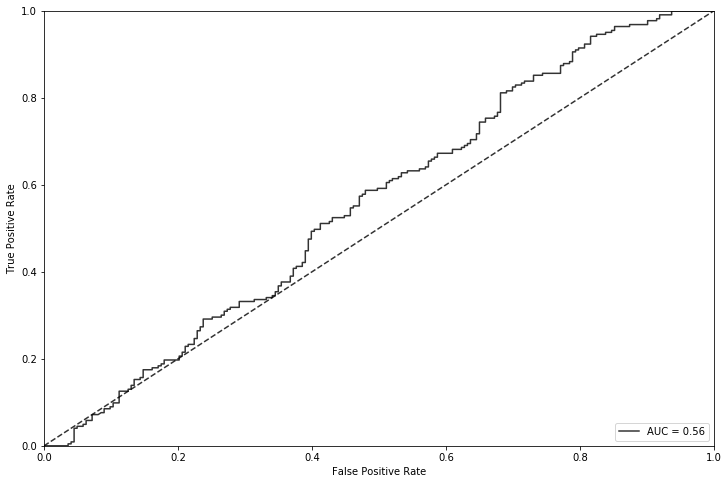

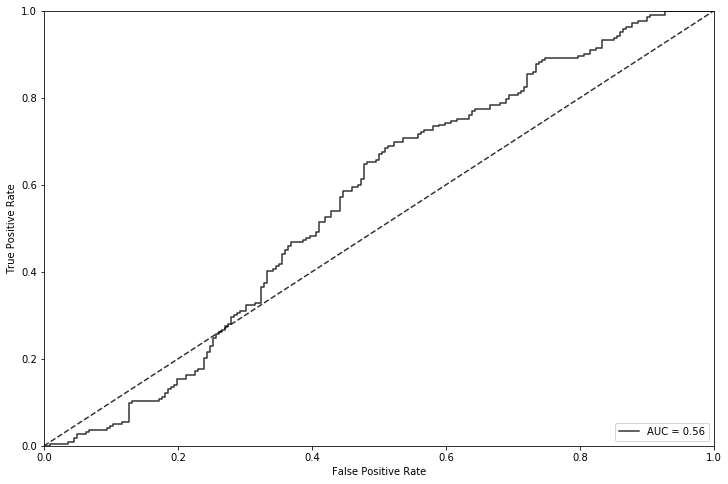

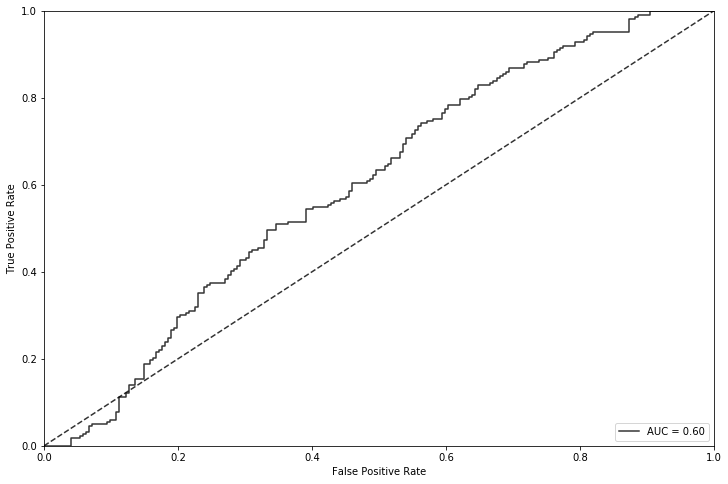

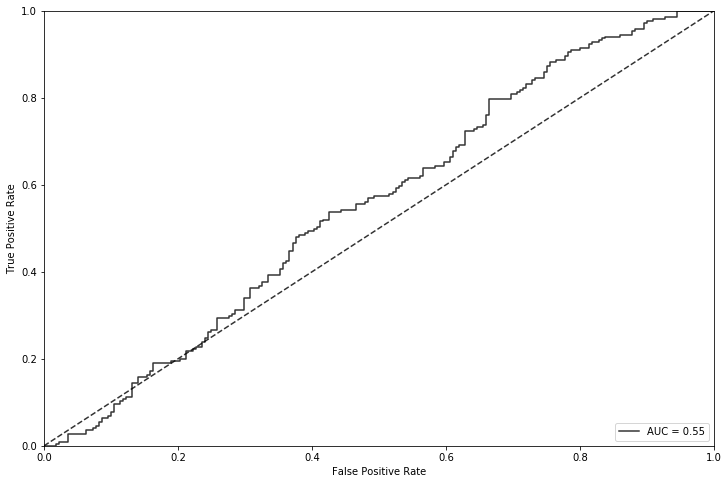

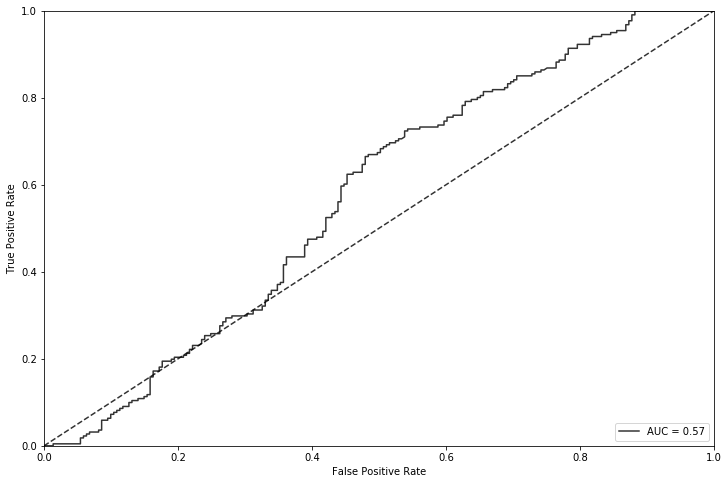

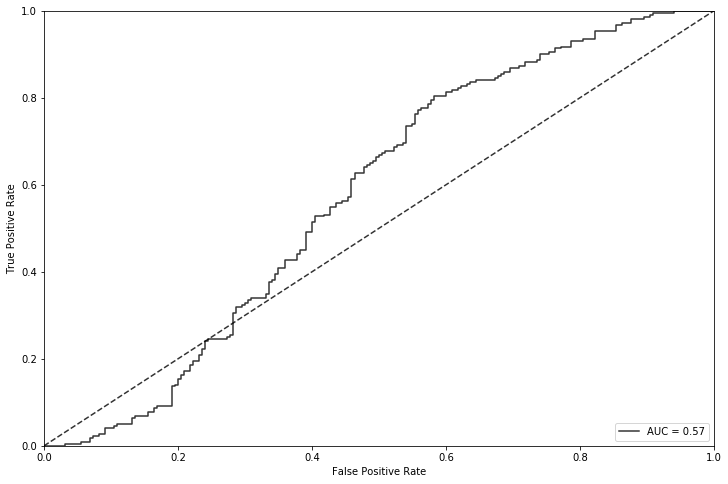

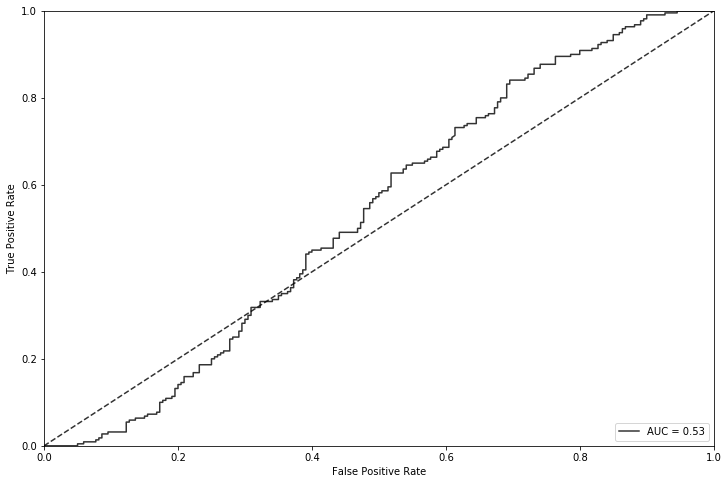

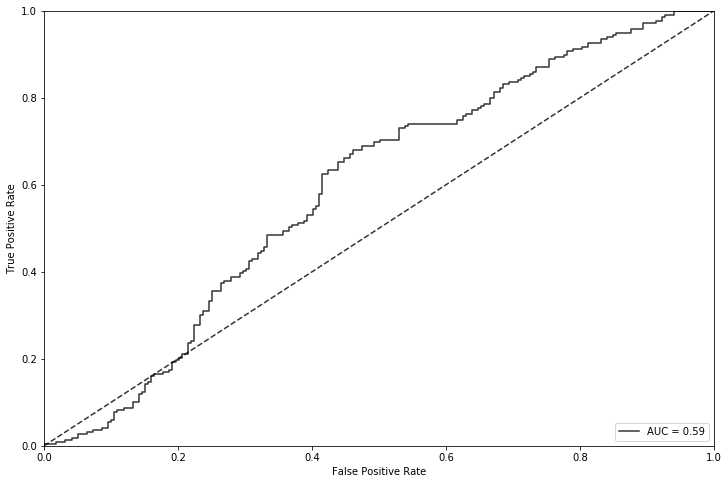

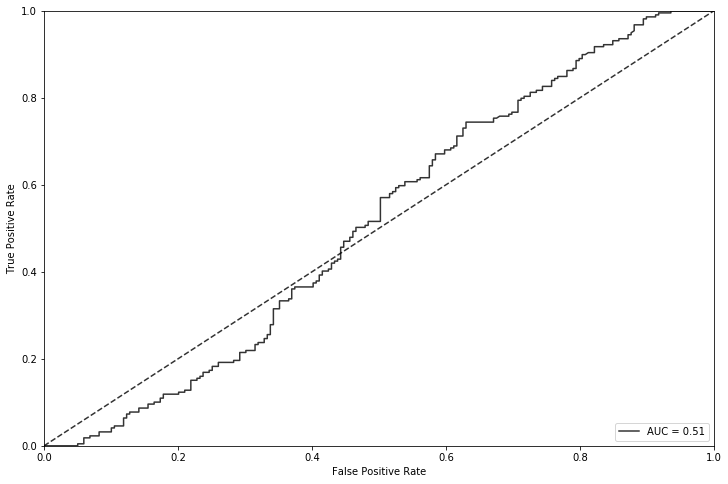

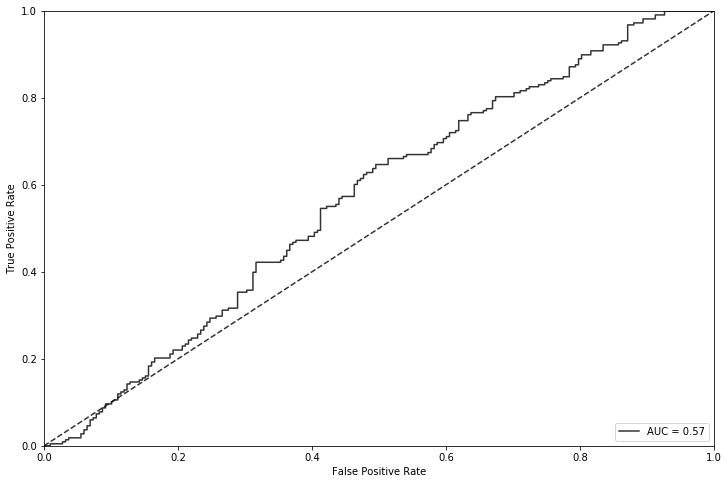

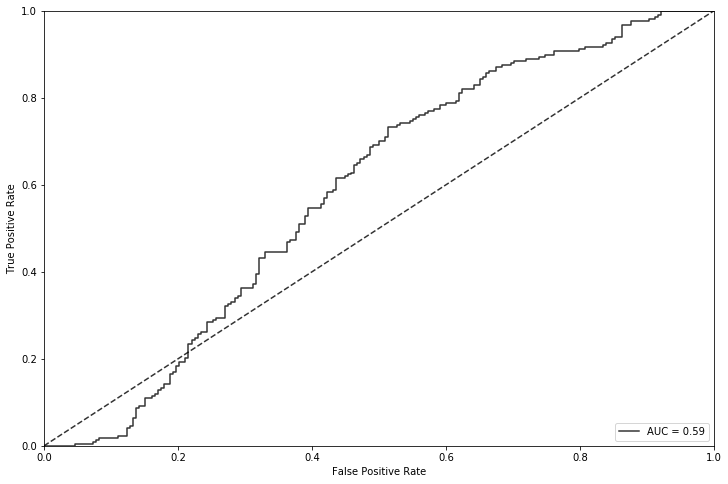

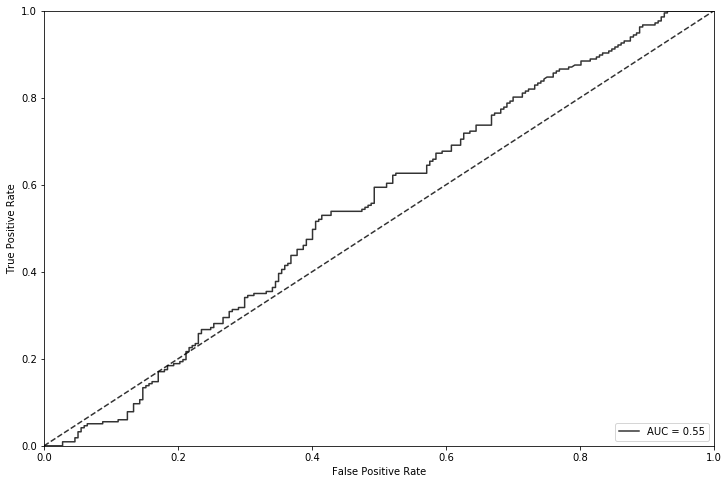

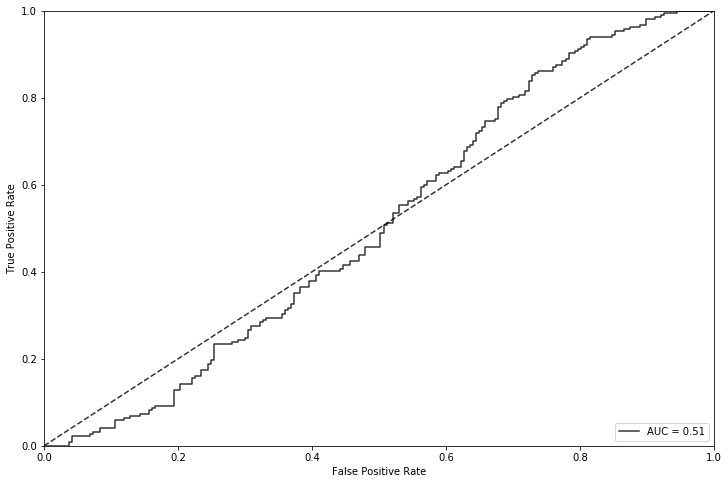

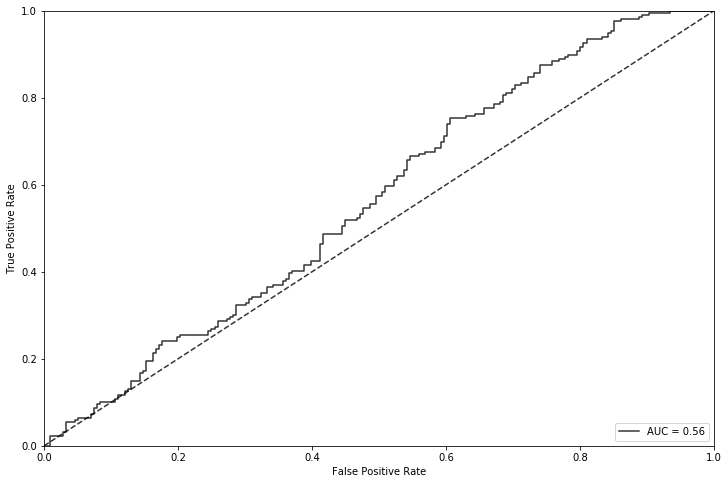

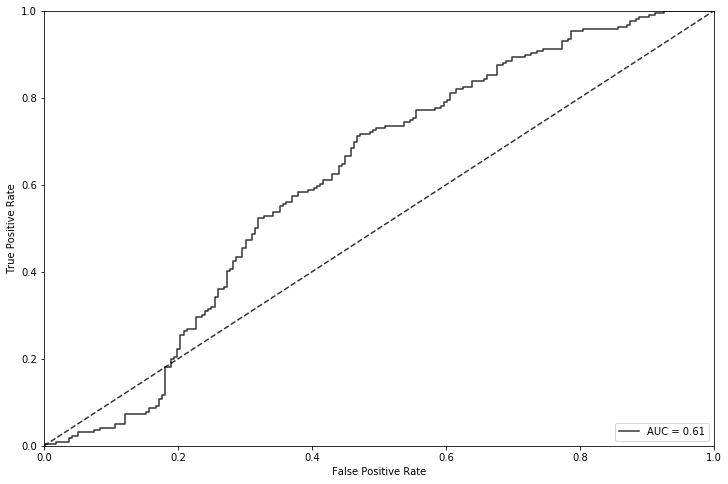

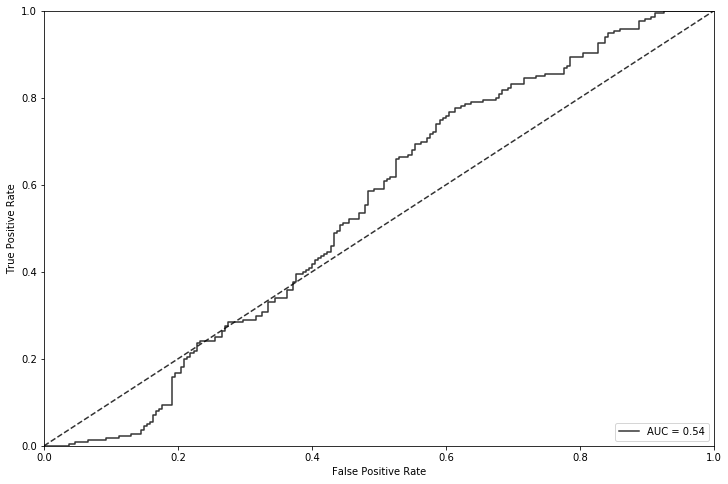

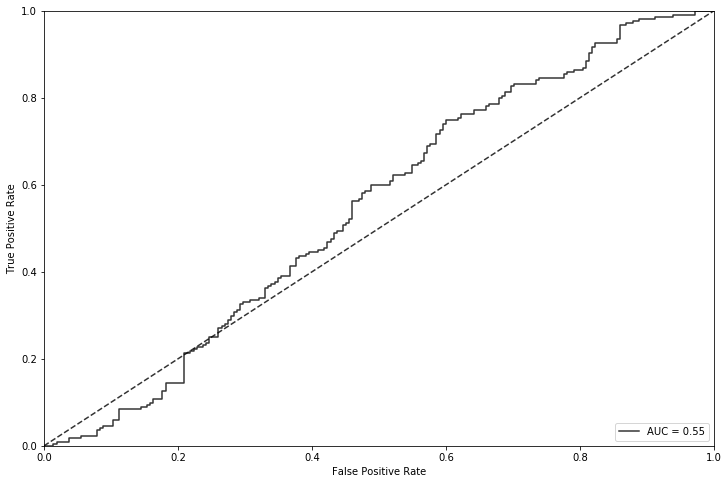

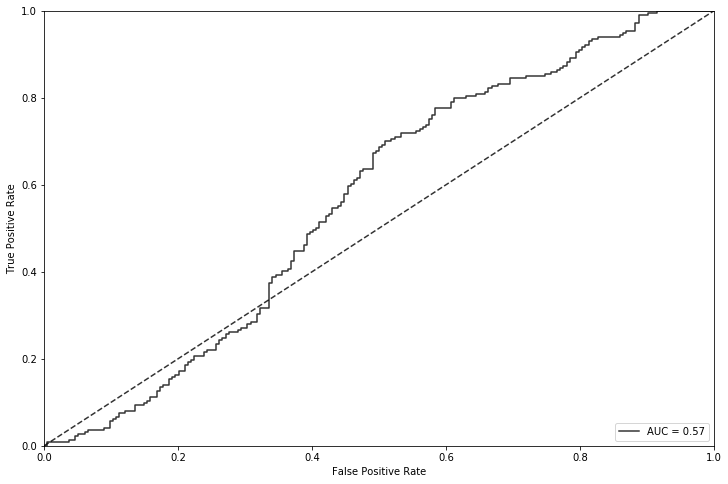

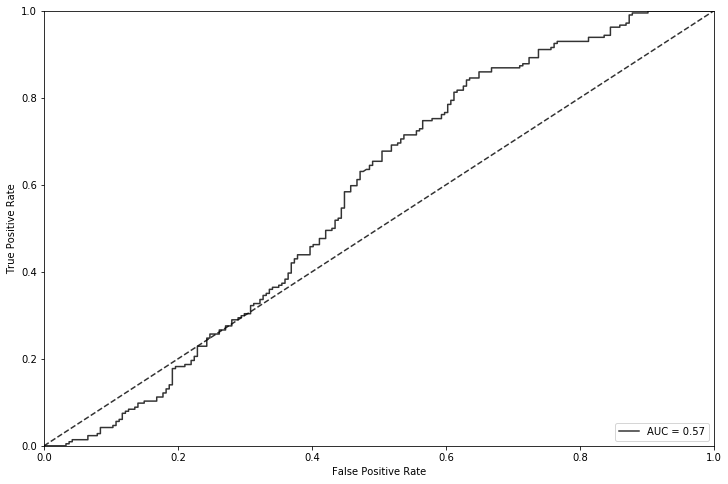

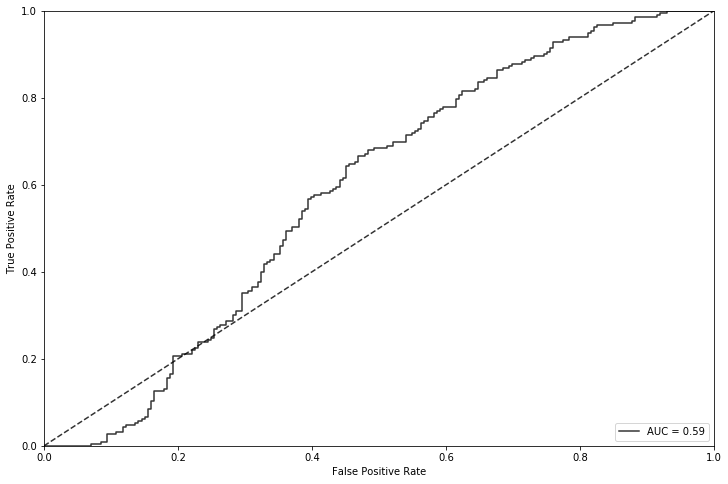

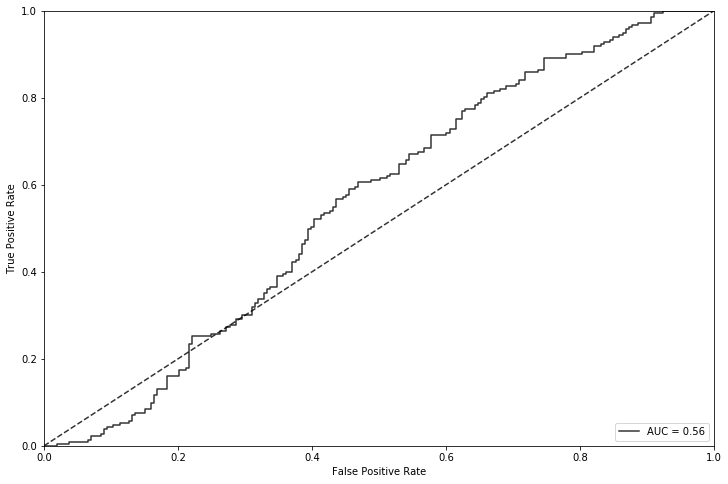

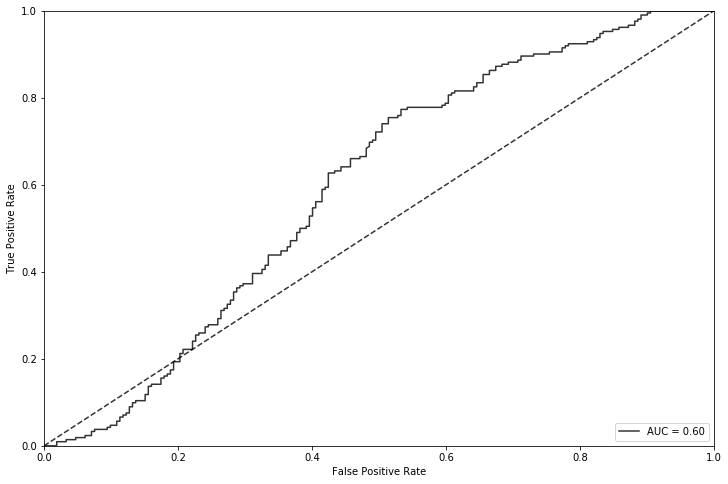

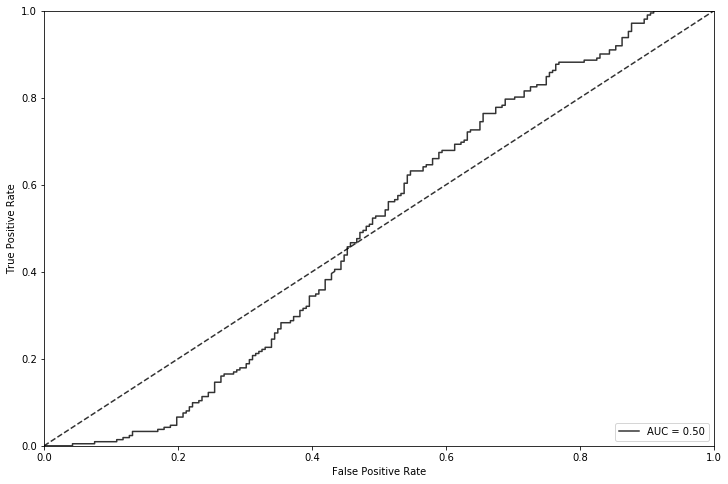

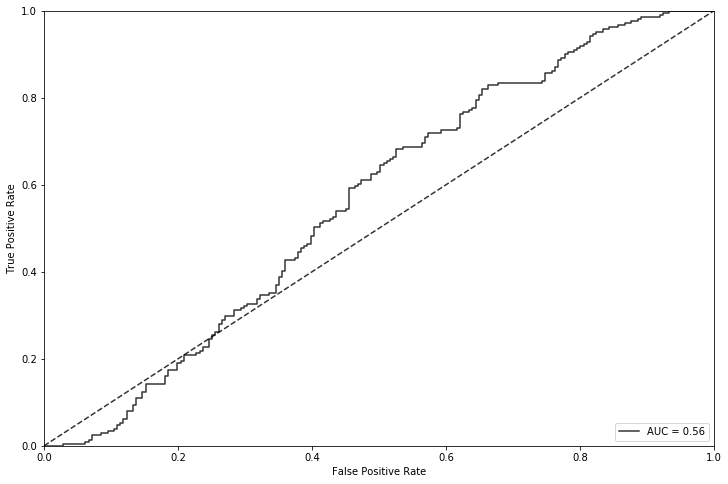

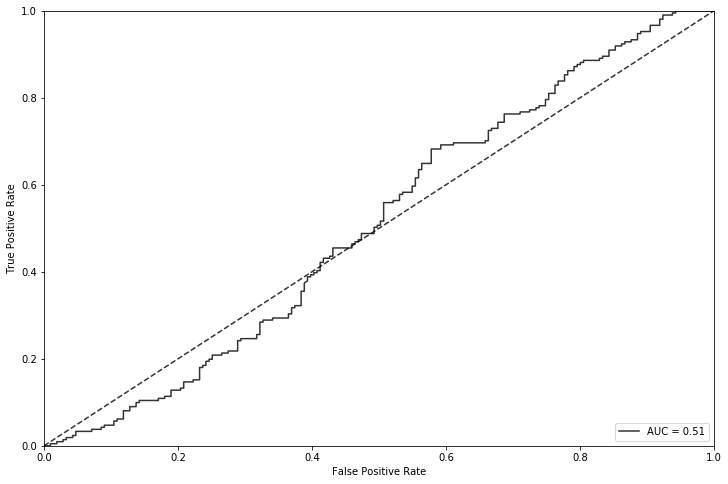

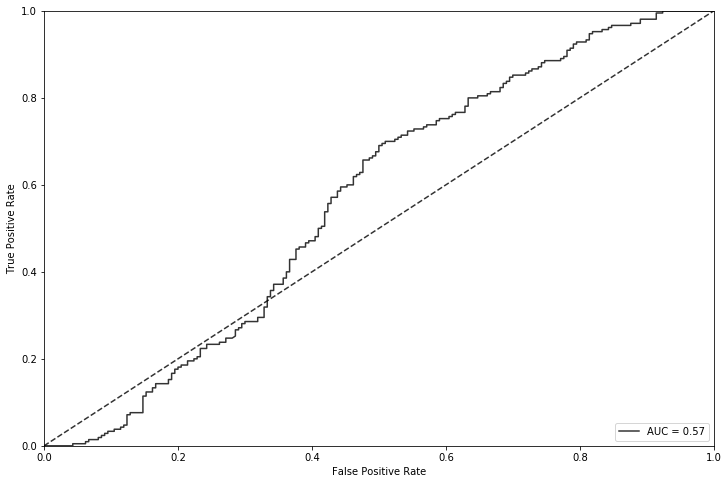

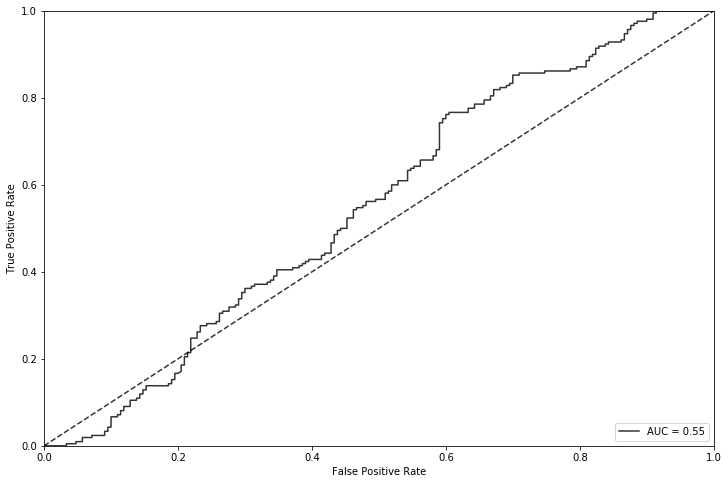

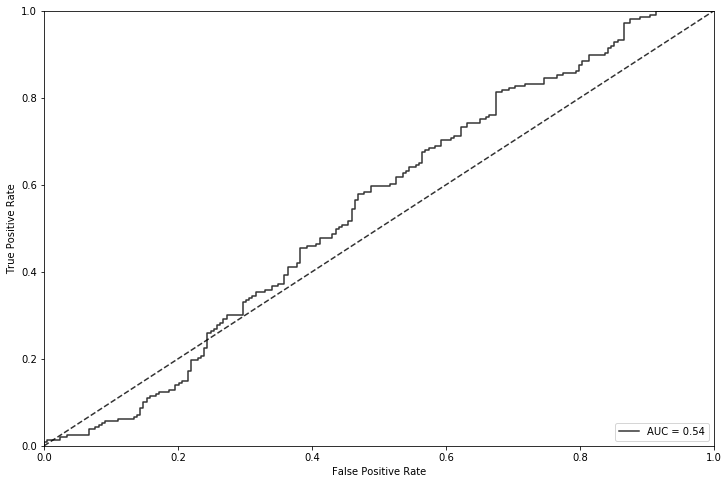

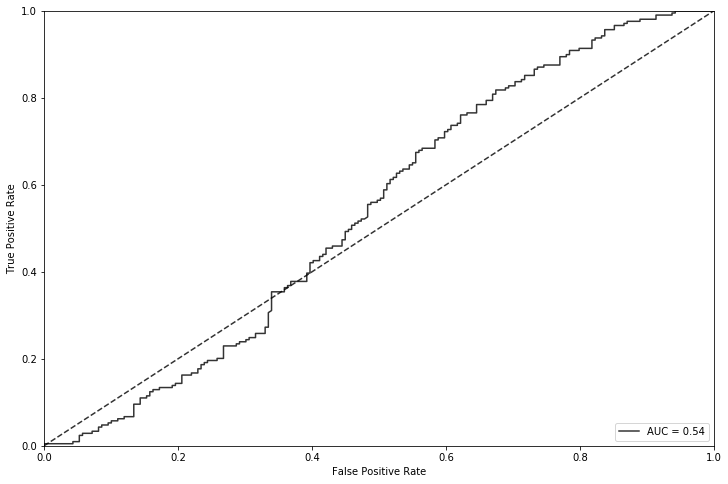

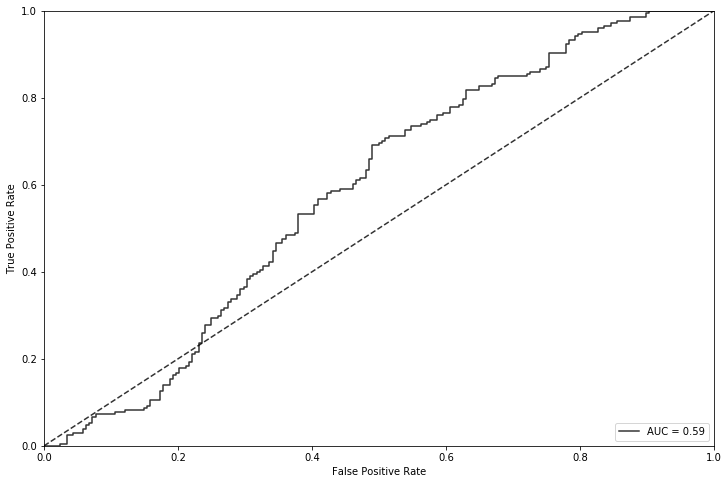

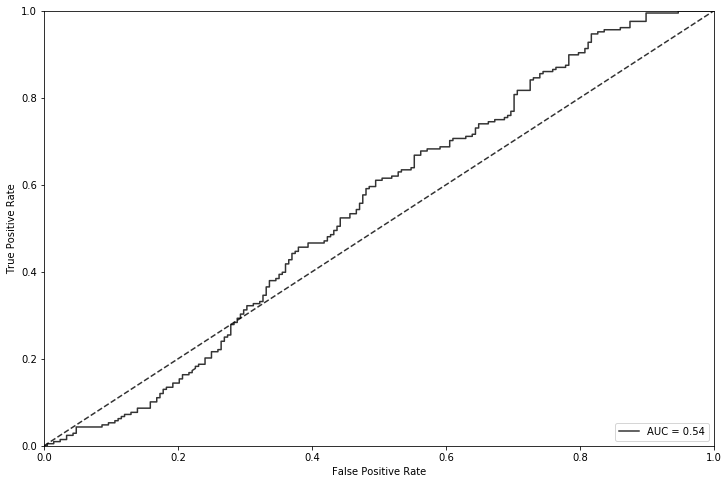

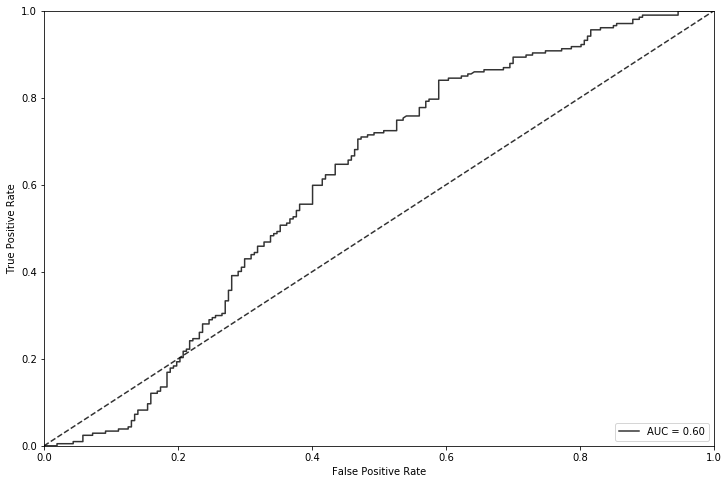

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def roc(y_test, preds, iteration, name):
    alpha = min(iteration+0.2,0.8)
    #alp = 1
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    #plt.title('Iteration: '+ str(name))
    plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, 'black', label = 'AUC = %0.2f' % roc_auc,alpha=alpha)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--', alpha=alpha)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('roc/roc_'+str(name)+".png")
    plt.show()
    return roc_auc

gbs = gbs_base.copy()

n = 579
iterations = 165
auroc = iterations*[0]

for ite in range(iterations):
    
    gbs = gbs.reindex(np.random.permutation(gbs.index))

    fst = int(n/2) #first half
    lst = n - fst  #second half

    df_1 = gbs.head(fst).copy()
    df_2 = gbs.tail(lst).copy()

    train = pd.concat([gesis.sample(n=lst), df_2])
    test = pd.concat([gesis.sample(n=fst), df_1])

    y = train.Umfrage
    X = train.drop(columns=['Umfrage'], axis=1).copy()
    clf = RandomForestClassifier(n_estimators=500, max_depth=6)
    clf.fit(X, y)

    y_test = test.Umfrage
    X_test = test.drop(columns=['Umfrage'], axis=1).copy()

    preds = [i[1] for i in clf.predict_proba(X_test)]
    
    auroc[ite] = roc(y_test, preds, ite/iterations, ite) 
    
    rem = df_1.drop(columns = ['Umfrage'], axis=1)
    result = [i[1] for i in clf.predict_proba(rem)]

    gbs = gbs.drop(gbs.index[np.argmax(result)]).copy()
    n = n-1

In [64]:
from PIL import Image

for ite in range(iterations):
    img = Image.open('roc/roc_'+str(ite)+".png")
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    img.save('roc/roc_'+str(ite)+".png", "PNG")

for ite in range(iterations):
    background = Image.open("roc/roc_1.png")
    foreground = Image.open("roc/roc_"+str(ite)+".png")
    Image.alpha_composite(background,foreground).save("roc/roc_1.png")